<a href="https://colab.research.google.com/github/OlgertHasko/Invasive-Ductal-Carcinoma-Classification/blob/main/Brest_Cancer_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#https://www.kaggle.com/paultimothymooney/breast-histopathology-images
!pip install plot_keras_history

## Importing Dependencies

In [4]:
#Importing dependencies needed for notebook
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os

import fnmatch
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, SeparableConv2D , BatchNormalization,Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.callbacks import EarlyStopping, ModelCheckpoint, ModelCheckpoint, ReduceLROnPlateau
from plot_keras_history import show_history, plot_history
from sklearn.metrics import confusion_matrix

In [5]:
#Setting image size and batch size
image_size = (50,50)
batch_size = 200

#Loading images from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/final project/base_dir/val_dir",
    validation_split=0.2,
    subset="training",
    seed=1651,
    image_size=image_size,
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/final project/base_dir/train_dir",
    image_size=image_size,
    batch_size=batch_size)

Found 31907 files belonging to 2 classes.
Using 25526 files for training.
Found 13301 files belonging to 2 classes.


In [ ]:
#Checking Class names
class_names = train_ds.class_names
print(class_names)

['a_no_idc', 'b_has_idc']


In [ ]:
#Checking size of imagees and labels
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(f"Labels for train ds: {labels_batch}")
  break

(200, 50, 50, 3)
Labels for train ds: [1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0
 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0
 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1
 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0
 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0]


In [ ]:
test_labels= np.concatenate([y for x, y in test_ds], axis=0)

In [6]:
#Setting # epochs used in our modeling
epochs = 100

In [7]:
#Creating function to evaluate our models

def model_eval(model):#input current model
  results_train = model.evaluate(train_ds) #evaluates train input
  results_test = model.evaluate(test_ds) #evaluates test input
  pred = model.predict(test_ds)
  preds = np.where(pred>0.5, 1,0)#if probability is less than .5 assign 0 if greater than 0 assign 1
  cm  = confusion_matrix(test_labels, preds, normalize="true")
  return f'Train Loss: {results_train[0]}, Train Accuracy: {results_train[1]} \n Test Loss: {results_test[0]}, Test Accuracy: {results_test[1]}.'

In [8]:
#Setting autotune to pre-fetch train and validation data
tpain = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=tpain)

In [9]:
#Setting callback that are going to be used in every model
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 15, restore_best_weights=True)
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=1e-15)

## 1st Model

In [ ]:
data_augmentation = keras.Sequential()

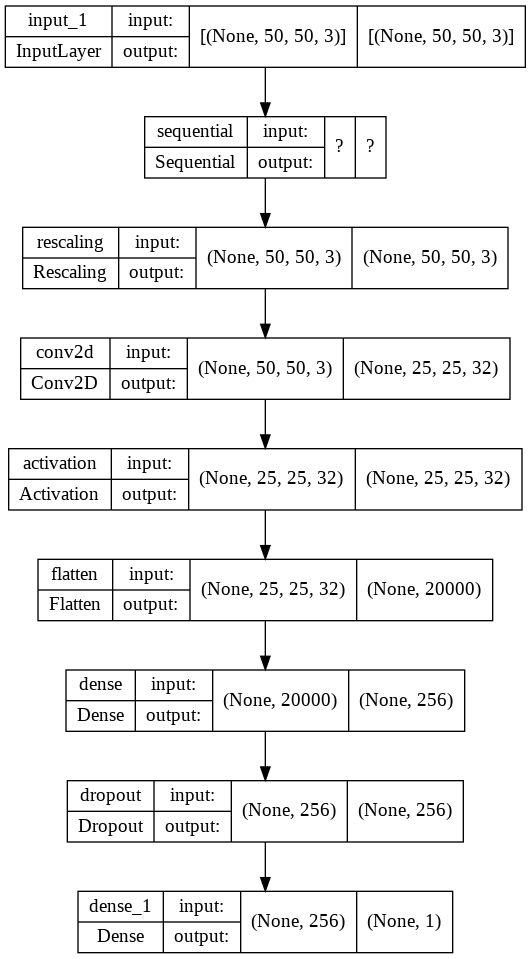

In [ ]:
#Setting up initial model
#Guide for settin up functional API https://keras.io/guides/functional_api/
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#Checking Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 256)               512025

In [ ]:
#Creating checkpoints for model
#ModelCheckpoint to save the best model
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 1/model1.h5",monitor= "val_loss", save_best_only=True )
#Checkpoint for Tensorboard logs
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 1/Model1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
#Compiling Model and fitting
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"])
model1 = model.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=1, validation_data = test_ds)

Epoch 1/100
86/86 [==============================] - 188s 2s/step - loss: 0.6830 - accuracy: 0.7050 - val_loss: 0.4751 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 2/100
86/86 [==============================] - 18s 194ms/step - loss: 0.4815 - accuracy: 0.7863 - val_loss: 0.5050 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 3/100
86/86 [==============================] - 18s 200ms/step - loss: 0.4606 - accuracy: 0.7983 - val_loss: 0.4411 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 4/100
86/86 [==============================] - 18s 194ms/step - loss: 0.4605 - accuracy: 0.7958 - val_loss: 0.5607 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 5/100
86/86 [==============================] - 17s 191ms/step - loss: 0.4452 - accuracy: 0.8054 - val_loss: 0.6854 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 6/100
86/86 [==============================] - 18s 198ms/step - loss: 0.4376 - accuracy: 0.8072 - val_loss: 0.4316 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 7/100
86/86 [==============================] - 17s 192

In [ ]:
 model.evaluate(test_ds)

45/45 [==============================] - 6s 111ms/step - loss: 0.4167 - accuracy: 0.8111


[0.4166540801525116, 0.8110668659210205]

In [ ]:
model1.history['accuracy'][:10]

[0.7050458192825317,
 0.7863355278968811,
 0.798284113407135,
 0.7958160042762756,
 0.805414080619812,
 0.8071770071983337,
 0.815913200378418,
 0.8189297318458557,
 0.8224946856498718,
 0.8313092589378357]

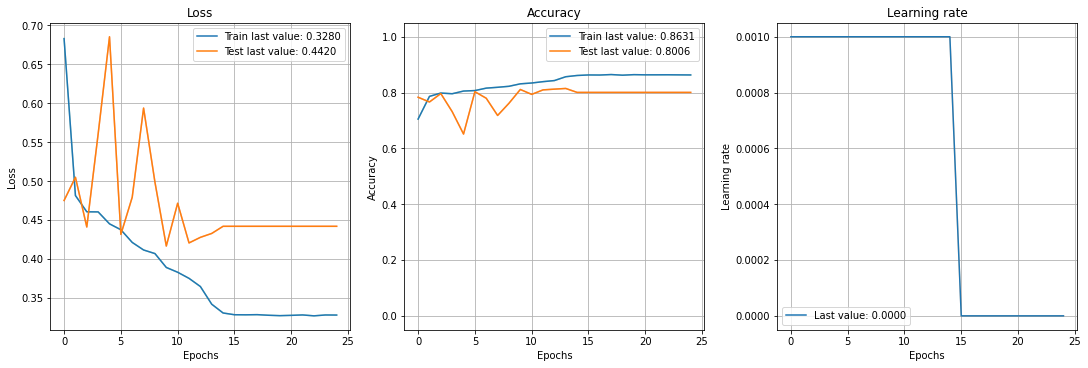

In [ ]:
show_history(model1)
plot_history(model1, path="/content/drive/Othercomputers/My Computer/final project/Presentation Images/model1.png")
plt.close()

## 2nd Model
Adding more layers and more image augmentations

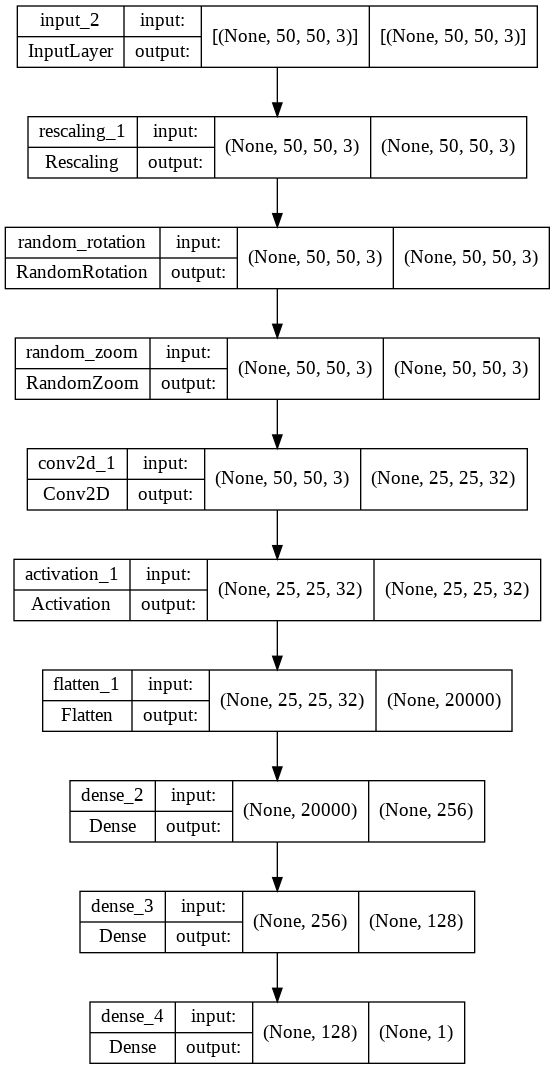

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)  

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model2 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 50, 50, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 50, 50, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 25, 25, 32)        0         
                                                           

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 2/model2.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 2/Model2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])
model_2 = model2.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2,validation_data = test_ds )

Epoch 1/100
86/86 - 19s - loss: 0.4083 - accuracy: 0.8218 - recall_1: 0.8181 - val_loss: 0.3605 - val_accuracy: 0.8384 - val_recall_1: 0.5940 - lr: 0.0010 - 19s/epoch - 218ms/step
Epoch 2/100
86/86 - 19s - loss: 0.3787 - accuracy: 0.8369 - recall_1: 0.8304 - val_loss: 0.3880 - val_accuracy: 0.8228 - val_recall_1: 0.4853 - lr: 0.0010 - 19s/epoch - 218ms/step
Epoch 3/100
86/86 - 18s - loss: 0.3776 - accuracy: 0.8372 - recall_1: 0.8297 - val_loss: 0.3957 - val_accuracy: 0.8247 - val_recall_1: 0.8314 - lr: 0.0010 - 18s/epoch - 204ms/step
Epoch 4/100
86/86 - 18s - loss: 0.3852 - accuracy: 0.8321 - recall_1: 0.8222 - val_loss: 0.3526 - val_accuracy: 0.8486 - val_recall_1: 0.7455 - lr: 0.0010 - 18s/epoch - 209ms/step
Epoch 5/100
86/86 - 18s - loss: 0.3825 - accuracy: 0.8323 - recall_1: 0.8269 - val_loss: 0.3839 - val_accuracy: 0.8342 - val_recall_1: 0.8113 - lr: 0.0010 - 18s/epoch - 206ms/step
Epoch 6/100
86/86 - 18s - loss: 0.3774 - accuracy: 0.8362 - recall_1: 0.8321 - val_loss: 0.3741 - va

In [ ]:
#model_eval(model2) 
model2.evaluate(train_ds)
model2.evaluate(test_ds)

45/45 [==============================] - 6s 102ms/step - loss: 0.3427 - accuracy: 0.8477 - recall_1: 0.6688


[0.34273776412010193, 0.8476806282997131, 0.6688481569290161]

In [ ]:
model2.predict(test_ds, verbose=1, batch_size=10)

45/45 [==============================] - 6s 103ms/step


array([[0.05475277],
       [0.19150457],
       [0.8212663 ],
       ...,
       [0.07540554],
       [0.03876537],
       [0.09390032]], dtype=float32)

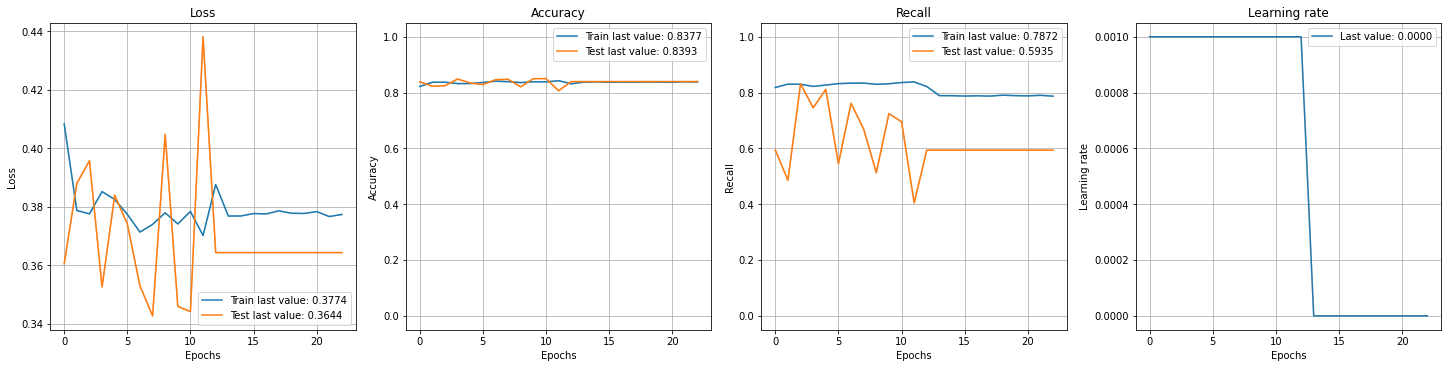

In [ ]:
show_history(model_2)
plot_history(model_2, path="/content/drive/Othercomputers/My Computer/final project/Model 2/model2.png")
plt.close()

## 3rd Model
Changing Randomzoom and random rotation values to see changes in score


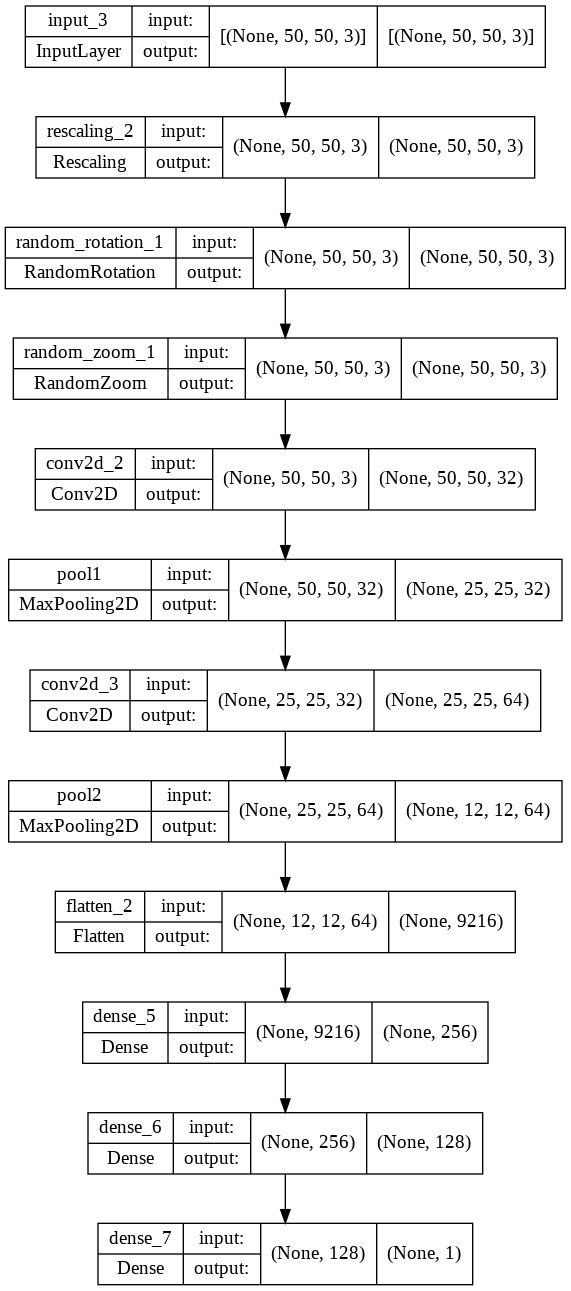

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomZoom(0.1)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model3 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model3, show_shapes=True)

In [ ]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 50, 50, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 25, 32)        0         
                                                           

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 3/model3.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 3/Model3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model3.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])
model_3 = model3.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2,validation_data = test_ds)

Epoch 1/100
86/86 - 26s - loss: 0.5556 - accuracy: 0.7195 - recall_2: 0.6777 - val_loss: 0.9618 - val_accuracy: 0.4897 - val_recall_2: 0.9545 - lr: 0.0010 - 26s/epoch - 305ms/step
Epoch 2/100
86/86 - 24s - loss: 0.4751 - accuracy: 0.7848 - recall_2: 0.7612 - val_loss: 0.4463 - val_accuracy: 0.7994 - val_recall_2: 0.5183 - lr: 0.0010 - 24s/epoch - 282ms/step
Epoch 3/100
86/86 - 24s - loss: 0.4711 - accuracy: 0.7876 - recall_2: 0.7577 - val_loss: 0.4377 - val_accuracy: 0.8020 - val_recall_2: 0.6717 - lr: 0.0010 - 24s/epoch - 274ms/step
Epoch 4/100
86/86 - 23s - loss: 0.4469 - accuracy: 0.7984 - recall_2: 0.7720 - val_loss: 0.7089 - val_accuracy: 0.6088 - val_recall_2: 0.9152 - lr: 0.0010 - 23s/epoch - 266ms/step
Epoch 5/100
86/86 - 23s - loss: 0.4395 - accuracy: 0.8036 - recall_2: 0.7846 - val_loss: 0.4903 - val_accuracy: 0.7663 - val_recall_2: 0.7958 - lr: 0.0010 - 23s/epoch - 271ms/step
Epoch 6/100
86/86 - 23s - loss: 0.4246 - accuracy: 0.8116 - recall_2: 0.7982 - val_loss: 0.4943 - va

In [ ]:
#model_eval3 = model_eval(model3)
model3.evaluate(train_ds)
model3.evaluate(test_ds)

45/45 [==============================] - 6s 119ms/step - loss: 0.3234 - accuracy: 0.8596 - recall_2: 0.7628


[0.32344621419906616, 0.8595594167709351, 0.7628272175788879]

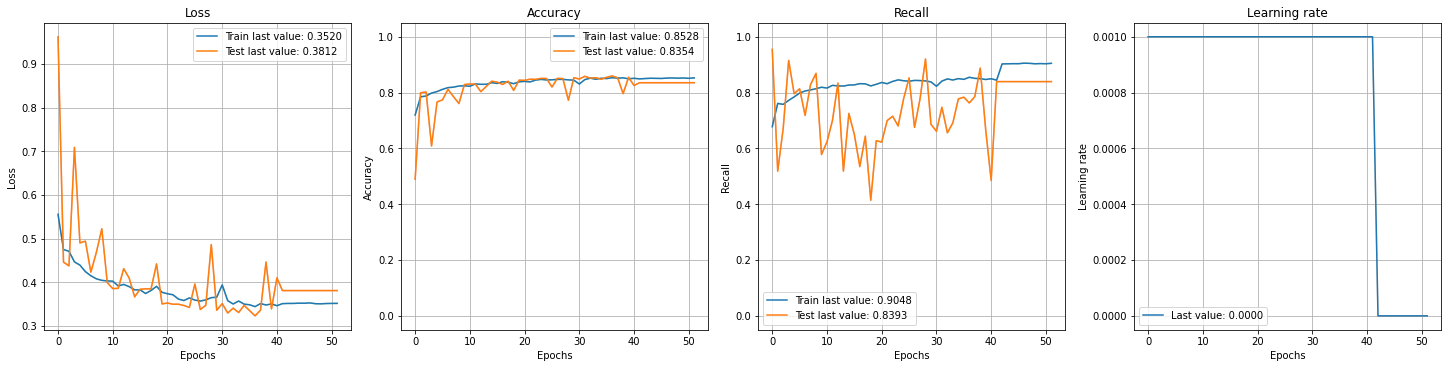

In [ ]:
show_history(model_3)
plot_history(model_3, path="/content/drive/Othercomputers/My Computer/final project/Model 3/model3.png")
plt.close()

accuracy on train and test data increased by lowering rotation and zoom, trying with no zoom

##4th model

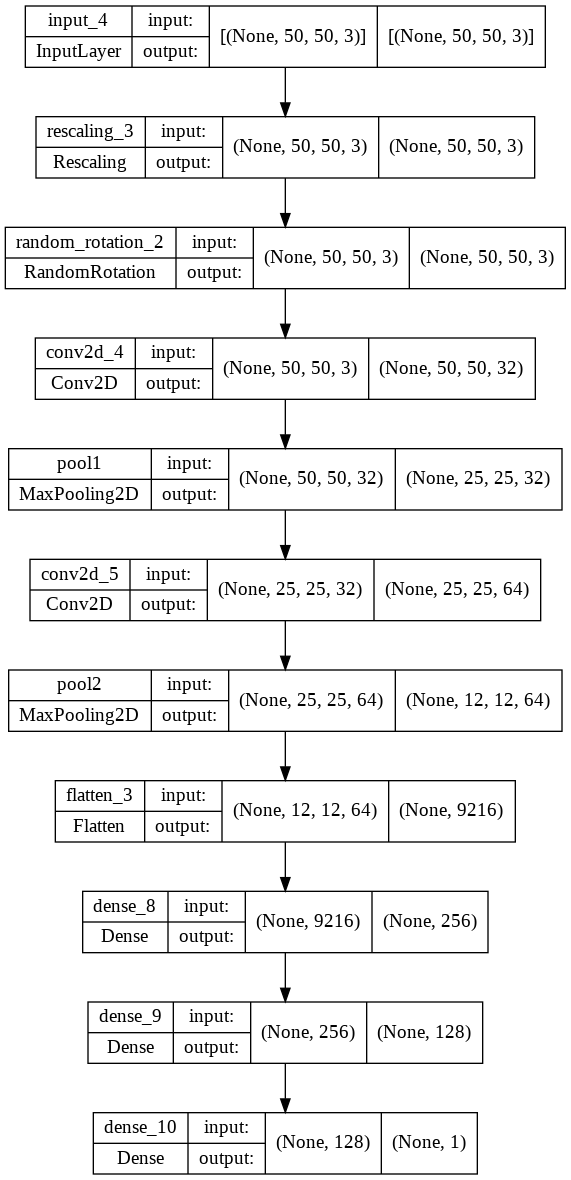

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model4 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model4, show_shapes=True)

In [ ]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_2 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                           

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 4/model4.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 4/Model4"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model4.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()]
)
model_4 = model4.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=1,validation_data = test_ds)

Epoch 1/100
86/86 [==============================] - 26s 277ms/step - loss: 0.5965 - accuracy: 0.6857 - recall_3: 0.6066 - val_loss: 0.4943 - val_accuracy: 0.7779 - val_recall_3: 0.6976 - lr: 1.0000e-04
Epoch 2/100
86/86 [==============================] - 23s 258ms/step - loss: 0.4785 - accuracy: 0.7905 - recall_3: 0.7617 - val_loss: 0.5738 - val_accuracy: 0.7278 - val_recall_3: 0.8351 - lr: 1.0000e-04
Epoch 3/100
86/86 [==============================] - 23s 256ms/step - loss: 0.4631 - accuracy: 0.7962 - recall_3: 0.7757 - val_loss: 0.5967 - val_accuracy: 0.7009 - val_recall_3: 0.8458 - lr: 1.0000e-04
Epoch 4/100
86/86 [==============================] - 23s 259ms/step - loss: 0.4546 - accuracy: 0.8005 - recall_3: 0.7815 - val_loss: 0.5720 - val_accuracy: 0.7115 - val_recall_3: 0.8275 - lr: 1.0000e-04
Epoch 5/100
86/86 [==============================] - 24s 265ms/step - loss: 0.4525 - accuracy: 0.8014 - recall_3: 0.7828 - val_loss: 0.5654 - val_accuracy: 0.7266 - val_recall_3: 0.8314 - 

In [ ]:
#model_eval4 = model_eval(model4)
model4.evaluate(train_ds) #evaluates train input
model4.evaluate(test_ds)

45/45 [==============================] - 6s 118ms/step - loss: 0.4943 - accuracy: 0.7779 - recall_3: 0.6976


[0.4942657947540283, 0.7779114246368408, 0.6976439952850342]

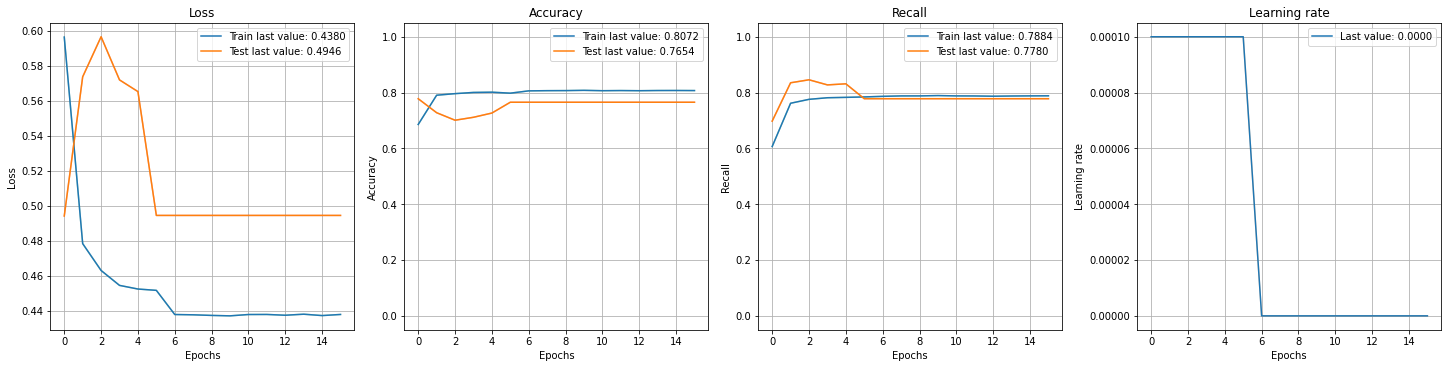

In [ ]:
show_history(model_4)
plot_history(model_4, path="/content/drive/Othercomputers/My Computer/final project/Model 4/model4.png")
plt.close()

accuracy on test data was higher with zoom, adding more image augments

## 5th Model

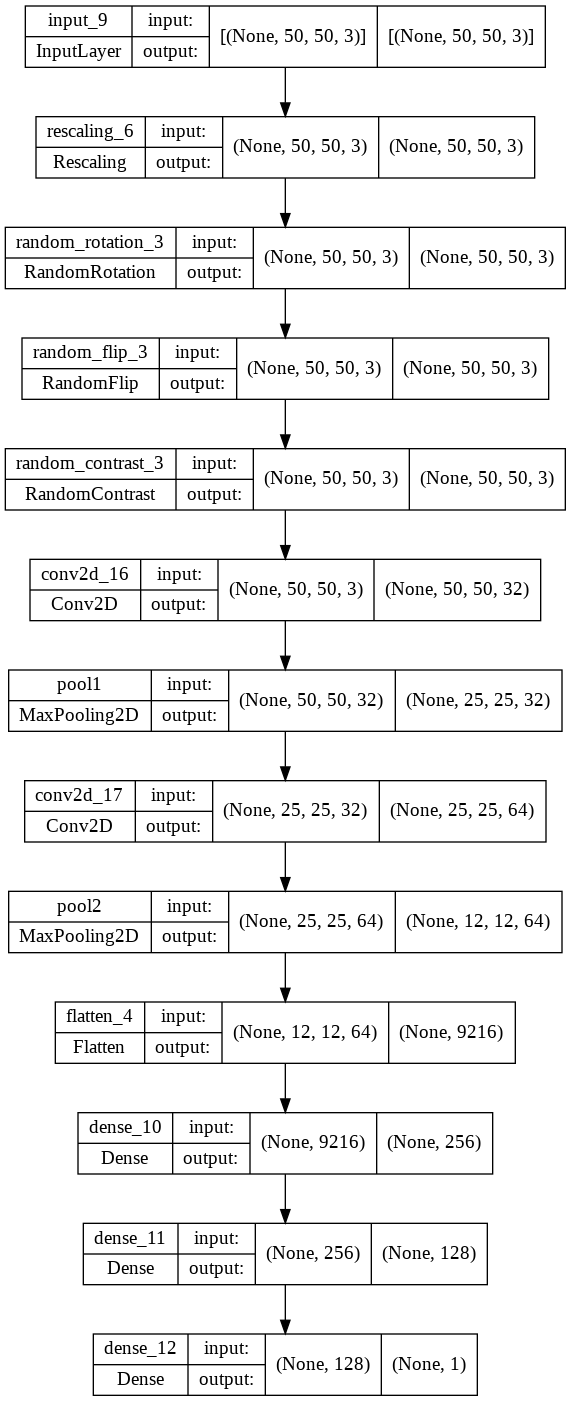

In [65]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model5 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model5, show_shapes=True)

In [ ]:
model5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 random_flip (RandomFlip)    (None, 50, 50, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 50, 50, 3)        0         
 rast)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        896 

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 5/model5.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 5/Model5"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model5.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()]
)
model_5 = model5.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2,validation_data = test_ds)

Epoch 1/100
86/86 - 26s - loss: 0.5951 - accuracy: 0.6931 - recall_4: 0.5944 - val_loss: 0.5872 - val_accuracy: 0.7179 - val_recall_4: 0.8199 - lr: 1.0000e-04 - 26s/epoch - 305ms/step
Epoch 2/100
86/86 - 24s - loss: 0.4808 - accuracy: 0.7871 - recall_4: 0.7550 - val_loss: 0.6031 - val_accuracy: 0.7108 - val_recall_4: 0.8463 - lr: 1.0000e-04 - 24s/epoch - 278ms/step
Epoch 3/100
86/86 - 24s - loss: 0.4650 - accuracy: 0.7950 - recall_4: 0.7713 - val_loss: 0.5447 - val_accuracy: 0.7431 - val_recall_4: 0.8073 - lr: 1.0000e-04 - 24s/epoch - 274ms/step
Epoch 4/100
86/86 - 24s - loss: 0.4577 - accuracy: 0.7976 - recall_4: 0.7760 - val_loss: 0.4413 - val_accuracy: 0.7988 - val_recall_4: 0.6416 - lr: 1.0000e-04 - 24s/epoch - 274ms/step
Epoch 5/100
86/86 - 24s - loss: 0.4512 - accuracy: 0.7996 - recall_4: 0.7758 - val_loss: 0.5439 - val_accuracy: 0.7387 - val_recall_4: 0.8186 - lr: 1.0000e-04 - 24s/epoch - 279ms/step
Epoch 6/100
86/86 - 23s - loss: 0.4455 - accuracy: 0.8018 - recall_4: 0.7829 - v

In [ ]:
#model_eval5 = model_eval(model5)
model5.evaluate(train_ds)
model5.evaluate(test_ds)

45/45 [==============================] - 6s 112ms/step - loss: 0.4413 - accuracy: 0.7988 - recall_4: 0.6416


[0.4412926733493805, 0.7988120913505554, 0.6416230201721191]

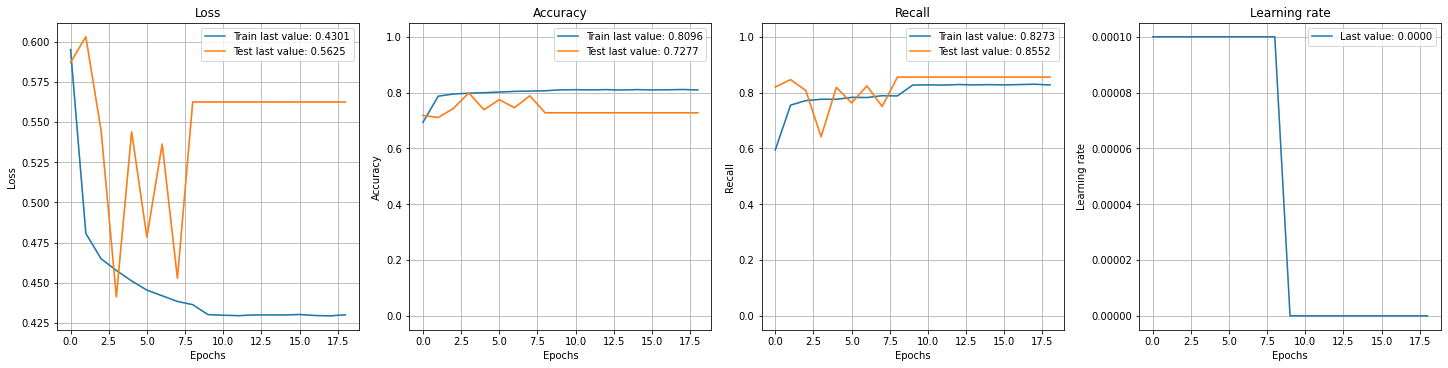

In [ ]:
show_history(model_5)
plot_history(model_5, path="/content/drive/Othercomputers/My Computer/final project/Model 5/model5.png")
plt.close()

Accuracy went from 79 to 81 on test

## 6th Model
Adding more layers 

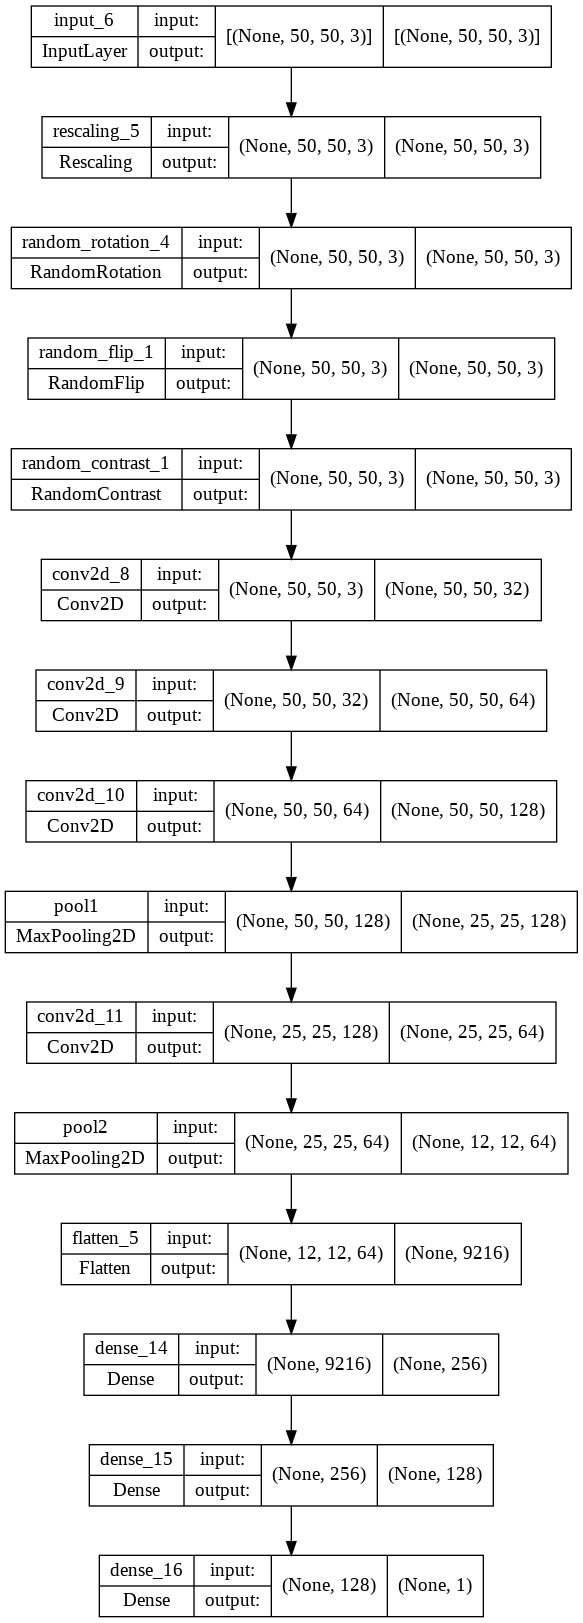

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)   
    x = Conv2D(64, 3, activation='relu', padding='same')(x)     
    x = Conv2D(128, 3, activation='relu', padding='same')(x)      
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model6 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model6, show_shapes=True)

In [ ]:
model6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_4 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 random_flip_1 (RandomFlip)  (None, 50, 50, 3)         0         
                                                                 
 random_contrast_1 (RandomCo  (None, 50, 50, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        896 

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 6/model6.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 6/Model6"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model6.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()]
)
model_6 = model6.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2, validation_data = test_ds)

Epoch 1/100
86/86 - 139s - loss: 0.5874 - accuracy: 0.6797 - recall_5: 0.5418 - val_loss: 0.5668 - val_accuracy: 0.7363 - val_recall_5: 0.8421 - lr: 1.0000e-04 - 139s/epoch - 2s/step
Epoch 2/100
86/86 - 137s - loss: 0.4664 - accuracy: 0.7941 - recall_5: 0.7640 - val_loss: 0.4506 - val_accuracy: 0.7958 - val_recall_5: 0.6623 - lr: 1.0000e-04 - 137s/epoch - 2s/step
Epoch 3/100
86/86 - 139s - loss: 0.4601 - accuracy: 0.7954 - recall_5: 0.7669 - val_loss: 0.4410 - val_accuracy: 0.7984 - val_recall_5: 0.6560 - lr: 1.0000e-04 - 139s/epoch - 2s/step
Epoch 4/100
86/86 - 138s - loss: 0.4512 - accuracy: 0.7994 - recall_5: 0.7771 - val_loss: 0.5940 - val_accuracy: 0.7199 - val_recall_5: 0.8513 - lr: 1.0000e-04 - 138s/epoch - 2s/step
Epoch 5/100
86/86 - 138s - loss: 0.4428 - accuracy: 0.8044 - recall_5: 0.7842 - val_loss: 0.6573 - val_accuracy: 0.6697 - val_recall_5: 0.8916 - lr: 1.0000e-04 - 138s/epoch - 2s/step
Epoch 6/100
86/86 - 140s - loss: 0.4413 - accuracy: 0.8055 - recall_5: 0.7884 - val_l

In [ ]:
#model_eval6 = model_eval(model6)
model6.evaluate(train_ds)
model6.evaluate(test_ds)

45/45 [==============================] - 13s 276ms/step - loss: 0.3869 - accuracy: 0.8245 - recall_5: 0.7563


[0.3869391679763794, 0.824524462223053, 0.7562827467918396]

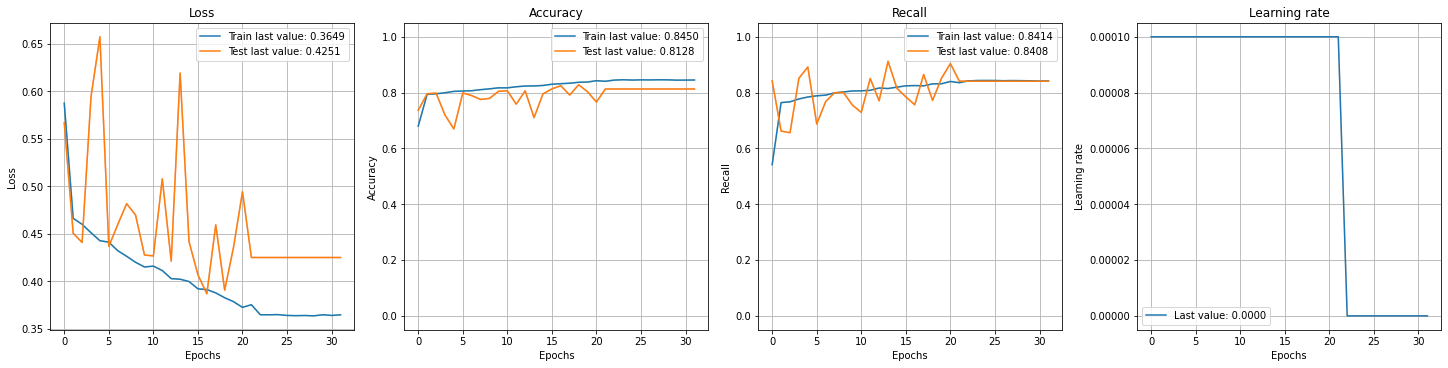

In [ ]:
show_history(model_6)
plot_history(model_6, path="/content/drive/Othercomputers/My Computer/final project/Model 6/model6.png")
plt.close()

Test accuracy increased by 1.2% and train accuracy increased by a bit


## 7th Model
adding more layers

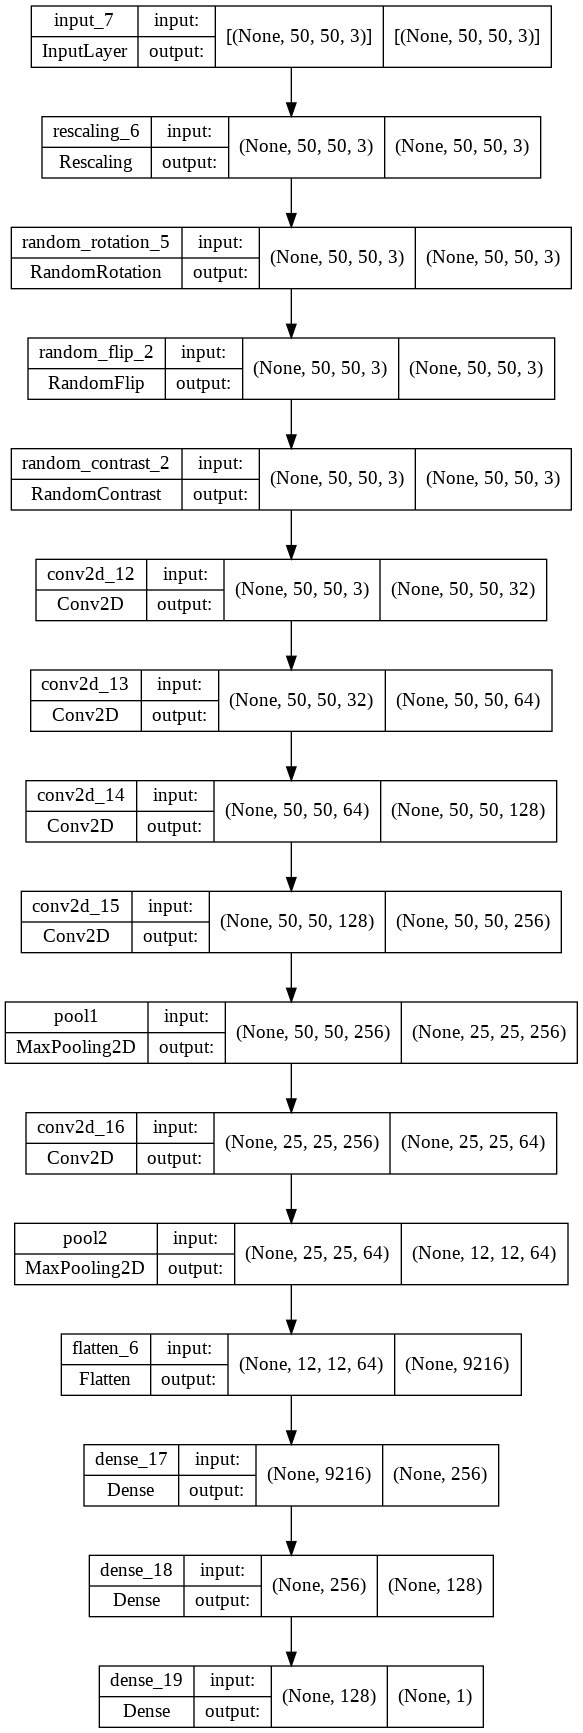

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)   
    x = Conv2D(64, 3, activation='relu', padding='same')(x)     
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)           
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)   
    
    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model7 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model7, show_shapes=True)

In [ ]:
model7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_5 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 random_flip_2 (RandomFlip)  (None, 50, 50, 3)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 50, 50, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        896 

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 7/model7.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 7/Model7"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model7.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

model_7 = model7.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2, validation_data = test_ds)

Epoch 1/100
86/86 - 367s - loss: 0.5614 - accuracy: 0.7000 - recall_6: 0.5166 - val_loss: 0.4704 - val_accuracy: 0.7869 - val_recall_6: 0.7045 - lr: 1.0000e-04 - 367s/epoch - 4s/step
Epoch 2/100
86/86 - 379s - loss: 0.4631 - accuracy: 0.7938 - recall_6: 0.7661 - val_loss: 0.4923 - val_accuracy: 0.7697 - val_recall_6: 0.7547 - lr: 1.0000e-04 - 379s/epoch - 4s/step
Epoch 3/100
86/86 - 368s - loss: 0.4483 - accuracy: 0.8018 - recall_6: 0.7758 - val_loss: 0.6663 - val_accuracy: 0.6628 - val_recall_6: 0.8874 - lr: 1.0000e-04 - 368s/epoch - 4s/step
Epoch 4/100
86/86 - 367s - loss: 0.4479 - accuracy: 0.7991 - recall_6: 0.7753 - val_loss: 0.4335 - val_accuracy: 0.8042 - val_recall_6: 0.6725 - lr: 1.0000e-04 - 367s/epoch - 4s/step
Epoch 5/100
86/86 - 372s - loss: 0.4470 - accuracy: 0.7983 - recall_6: 0.7724 - val_loss: 0.4690 - val_accuracy: 0.7827 - val_recall_6: 0.7254 - lr: 1.0000e-04 - 372s/epoch - 4s/step
Epoch 6/100
86/86 - 371s - loss: 0.4366 - accuracy: 0.8058 - recall_6: 0.7824 - val_l

In [ ]:
#model_eval7 = model_eval(model7)
model7.evaluate(train_ds)
model7.evaluate(test_ds)

45/45 [==============================] - 37s 790ms/step - loss: 0.3367 - accuracy: 0.8536 - recall_6: 0.7770


[0.336738258600235, 0.8536200523376465, 0.7769633531570435]

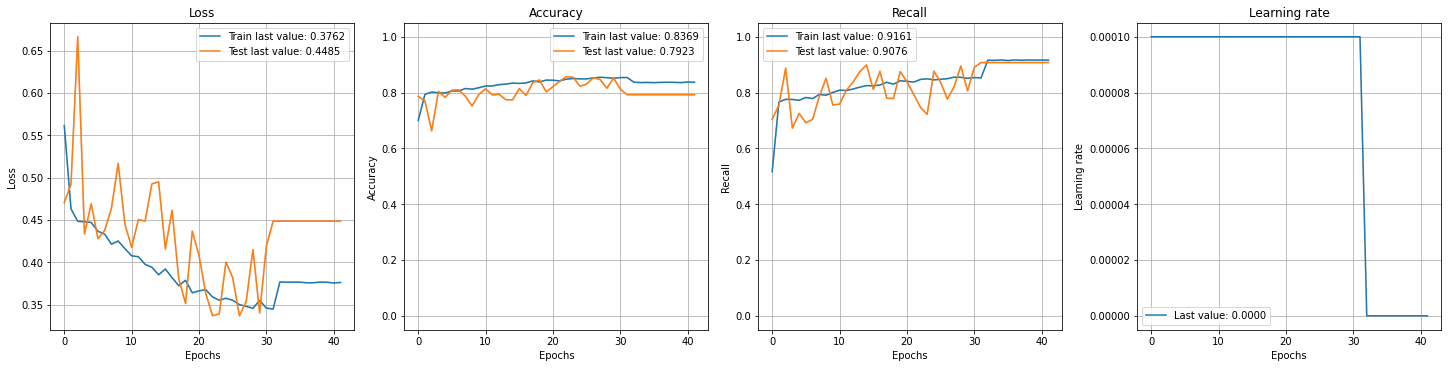

In [ ]:
show_history(model_7)
plot_history(model_7, path="/content/drive/Othercomputers/My Computer/final project/Model 2/model2.png")
plt.close()

Test Accuracy went up by 3% 

## 8th Model
adding more layers

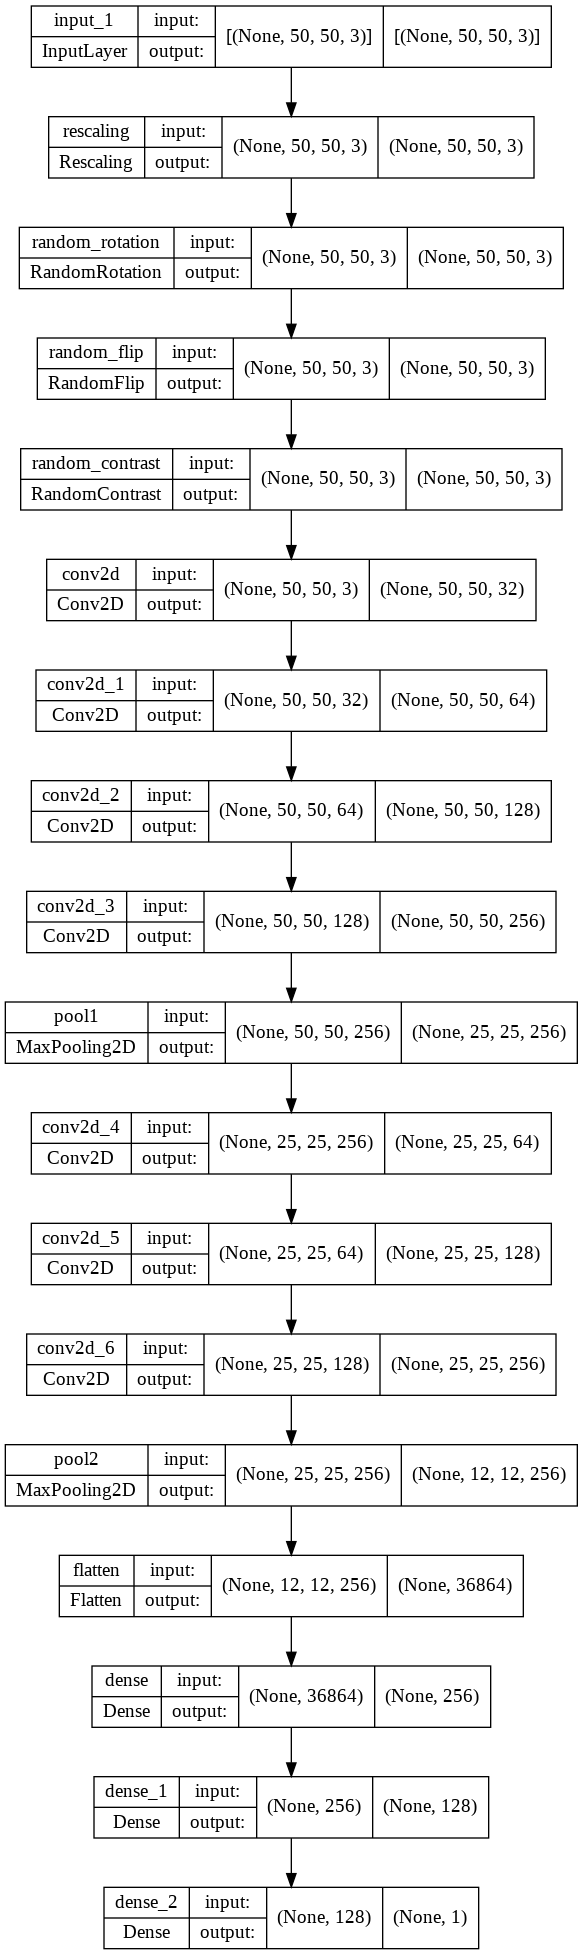

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)   
    x = Conv2D(64, 3, activation='relu', padding='same')(x)     
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)           
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)          
    x = MaxPooling2D((2,2), name='pool2')(x)   
    
    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model8 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model8, show_shapes=True)

In [ ]:
model8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 50, 50, 3)        0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 50, 50, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 50, 50, 3)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896   

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 8/model8.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 8/Model8"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model8.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()]
)
model_8 = model8.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2, validation_data = test_ds)

Epoch 1/100
86/86 - 433s - loss: 0.5668 - accuracy: 0.7009 - recall: 0.5926 - val_loss: 0.4531 - val_accuracy: 0.7910 - val_recall: 0.5987 - lr: 1.0000e-04 - 433s/epoch - 5s/step
Epoch 2/100
86/86 - 438s - loss: 0.4650 - accuracy: 0.7893 - recall: 0.7575 - val_loss: 0.5079 - val_accuracy: 0.7746 - val_recall: 0.7524 - lr: 1.0000e-04 - 438s/epoch - 5s/step
Epoch 3/100
86/86 - 434s - loss: 0.4479 - accuracy: 0.7991 - recall: 0.7716 - val_loss: 0.4577 - val_accuracy: 0.7893 - val_recall: 0.7120 - lr: 1.0000e-04 - 434s/epoch - 5s/step
Epoch 4/100
86/86 - 437s - loss: 0.4472 - accuracy: 0.7976 - recall: 0.7730 - val_loss: 0.6117 - val_accuracy: 0.7090 - val_recall: 0.8615 - lr: 1.0000e-04 - 437s/epoch - 5s/step
Epoch 5/100
86/86 - 433s - loss: 0.4403 - accuracy: 0.8035 - recall: 0.7839 - val_loss: 0.6078 - val_accuracy: 0.6997 - val_recall: 0.8720 - lr: 1.0000e-04 - 433s/epoch - 5s/step
Epoch 6/100
86/86 - 437s - loss: 0.4421 - accuracy: 0.8011 - recall: 0.7850 - val_loss: 0.4266 - val_accu

In [ ]:
#model_eval8 = model_eval(model8)
model8.evaluate(train_ds)
model8.evaluate(test_ds)

45/45 [==============================] - 46s 1s/step - loss: 0.3329 - accuracy: 0.8591 - recall: 0.7398


[0.3329254686832428, 0.8591083288192749, 0.7397905588150024]

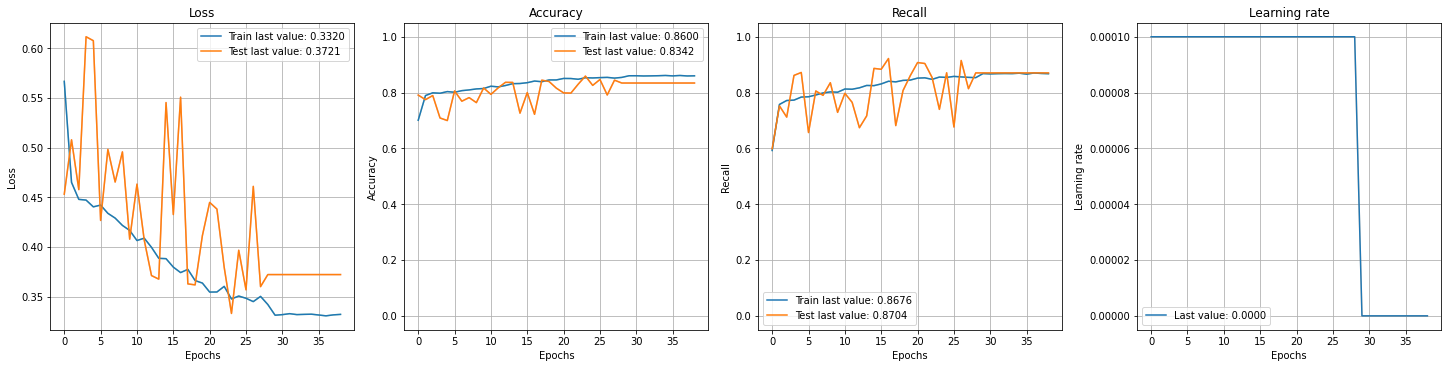

In [ ]:
show_history(model_8)
plot_history(model_8, path="/content/drive/Othercomputers/My Computer/final project/Model 8/model8.png")
plt.close()

Score went down by 4%

## 9th Model
Going back to previous layers, adding dense layer

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)   
    x = Conv2D(64, 3, activation='relu', padding='same')(x)     
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)           
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)   
    
    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model9 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model9, show_shapes=True)

In [ ]:
model9.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 50, 50, 3)        0         
 tation)                                                         
                                                                 
 random_flip_1 (RandomFlip)  (None, 50, 50, 3)         0         
                                                                 
 random_contrast_1 (RandomCo  (None, 50, 50, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        896 

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 9/model9.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 9/Model9"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model9.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()]
)
model_9 = model9.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2, validation_data = test_ds)

Epoch 1/100
86/86 - 365s - loss: 0.5799 - accuracy: 0.6906 - recall_1: 0.5481 - val_loss: 0.4921 - val_accuracy: 0.7775 - val_recall_1: 0.7243 - lr: 1.0000e-04 - 365s/epoch - 4s/step
Epoch 2/100
86/86 - 365s - loss: 0.4757 - accuracy: 0.7871 - recall_1: 0.7573 - val_loss: 0.4746 - val_accuracy: 0.7896 - val_recall_1: 0.7092 - lr: 1.0000e-04 - 365s/epoch - 4s/step
Epoch 3/100
86/86 - 361s - loss: 0.4626 - accuracy: 0.7918 - recall_1: 0.7611 - val_loss: 0.4735 - val_accuracy: 0.7844 - val_recall_1: 0.7144 - lr: 1.0000e-04 - 361s/epoch - 4s/step
Epoch 4/100
86/86 - 369s - loss: 0.4427 - accuracy: 0.8022 - recall_1: 0.7776 - val_loss: 0.5146 - val_accuracy: 0.7624 - val_recall_1: 0.7835 - lr: 1.0000e-04 - 369s/epoch - 4s/step
Epoch 5/100
86/86 - 366s - loss: 0.4523 - accuracy: 0.7964 - recall_1: 0.7715 - val_loss: 0.5586 - val_accuracy: 0.7442 - val_recall_1: 0.8291 - lr: 1.0000e-04 - 366s/epoch - 4s/step
Epoch 6/100
86/86 - 372s - loss: 0.4360 - accuracy: 0.8064 - recall_1: 0.7856 - val_l

In [ ]:
#model_eval9 = model_eval(model9)
model9.evaluate(train_ds)
model9.evaluate(test_ds)

45/45 [==============================] - 35s 752ms/step - loss: 0.4498 - accuracy: 0.8005 - recall_1: 0.7139


[0.4497874975204468, 0.8004661202430725, 0.713874340057373]

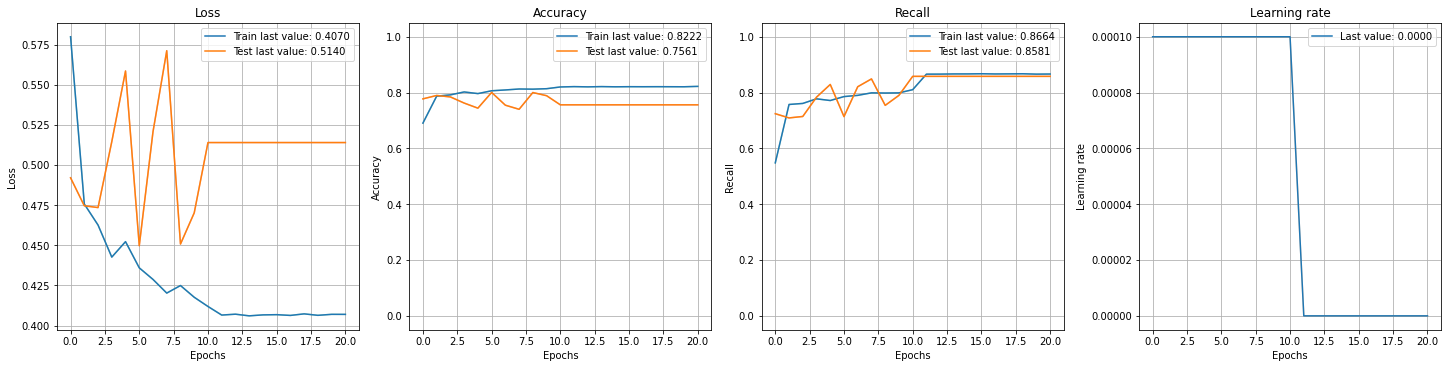

In [ ]:
show_history(model_9)
plot_history(model_9, path="/content/drive/Othercomputers/My Computer/final project/Model 2/model2.png")
plt.close()

Score went up from our previous model but down from 7th model

## 10th Model


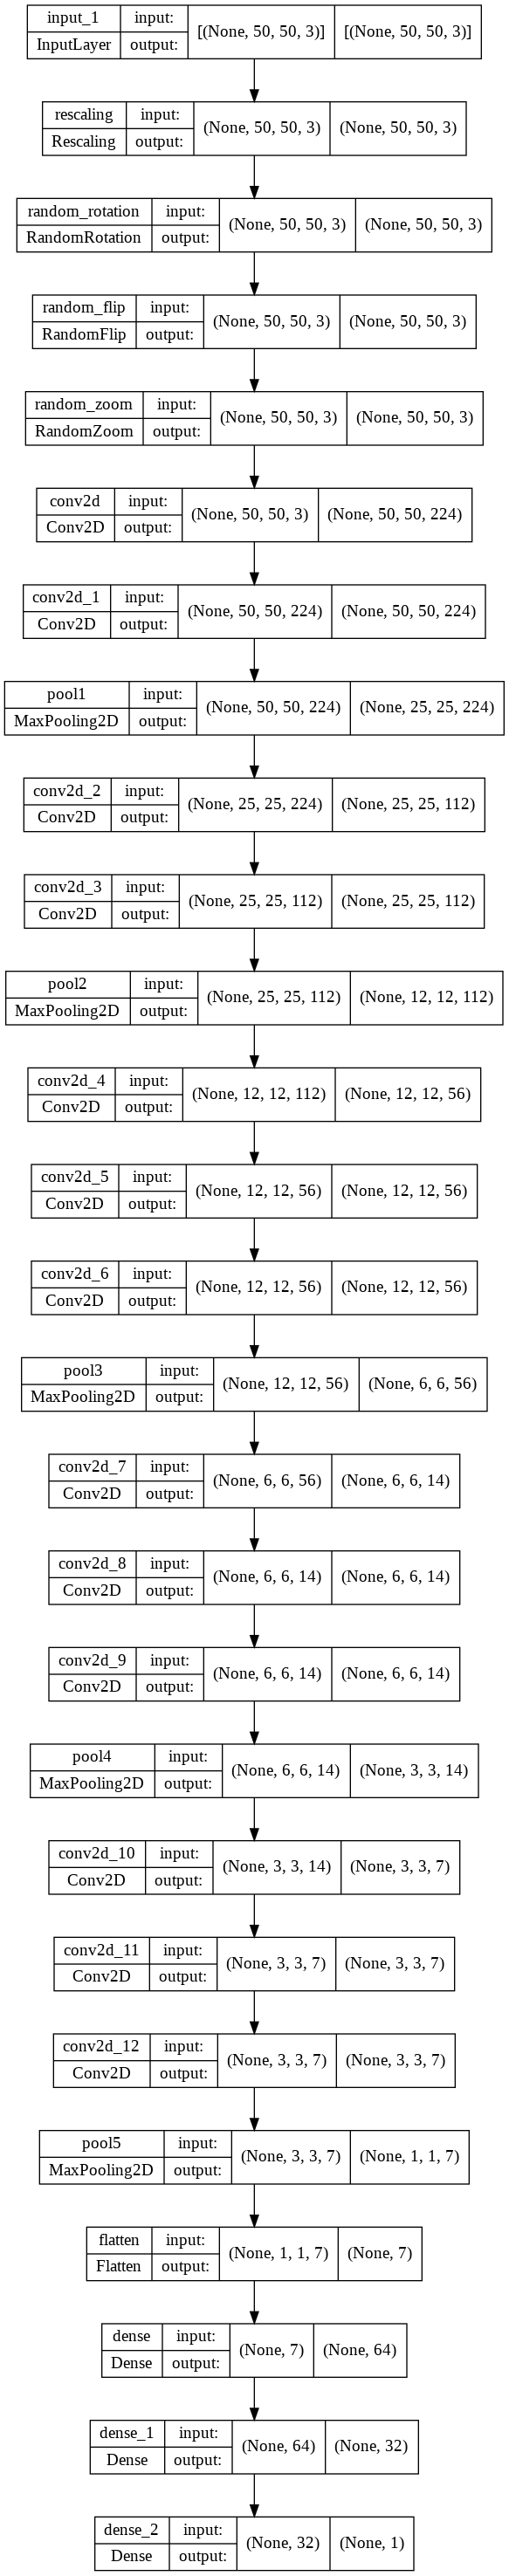

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomZoom(0.2)(x)

    # Entry block
    x = Conv2D(224, 3, activation='relu', padding='same')(x)   
    x = Conv2D(224, 3, activation='relu', padding='same')(x)             
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(112, 3, activation='relu', padding='same')(x)    
    x = Conv2D(112, 3, activation='relu', padding='same')(x)        
    x = MaxPooling2D((2,2), name='pool2')(x)   

    x = Conv2D(56, 3, activation='relu', padding='same')(x)    
    x = Conv2D(56, 3, activation='relu', padding='same')(x)  
    x = Conv2D(56, 3, activation='relu', padding='same')(x)          
    x = MaxPooling2D((2,2), name='pool3')(x) 

    x = Conv2D(14, 3, activation='relu', padding='same')(x)    
    x = Conv2D(14, 3, activation='relu', padding='same')(x)  
    x = Conv2D(14, 3, activation='relu', padding='same')(x)          
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(7, 3, activation='relu', padding='same')(x)    
    x = Conv2D(7, 3, activation='relu', padding='same')(x)  
    x = Conv2D(7, 3, activation='relu', padding='same')(x)          
    x = MaxPooling2D((2,2), name='pool5')(x)    

    x = Flatten()(x)     
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model10 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model10, show_shapes=True)

In [ ]:
model10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 50, 50, 3)        0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 50, 50, 3)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 224)       6272      
                                                             

In [ ]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 13/model13.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 13/Model13"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [ ]:
model10.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])
model_10 = model10.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=2, validation_data = test_ds)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
#model_eval11 = model_eval(model11)
model10.evaluate(train_ds)
model10.evaluate(test_ds)

In [ ]:
show_history(model_10)
plot_history(model_10, path="/content/drive/Othercomputers/My Computer/final project/Model 10/model10.png")
plt.close()

## Model 11

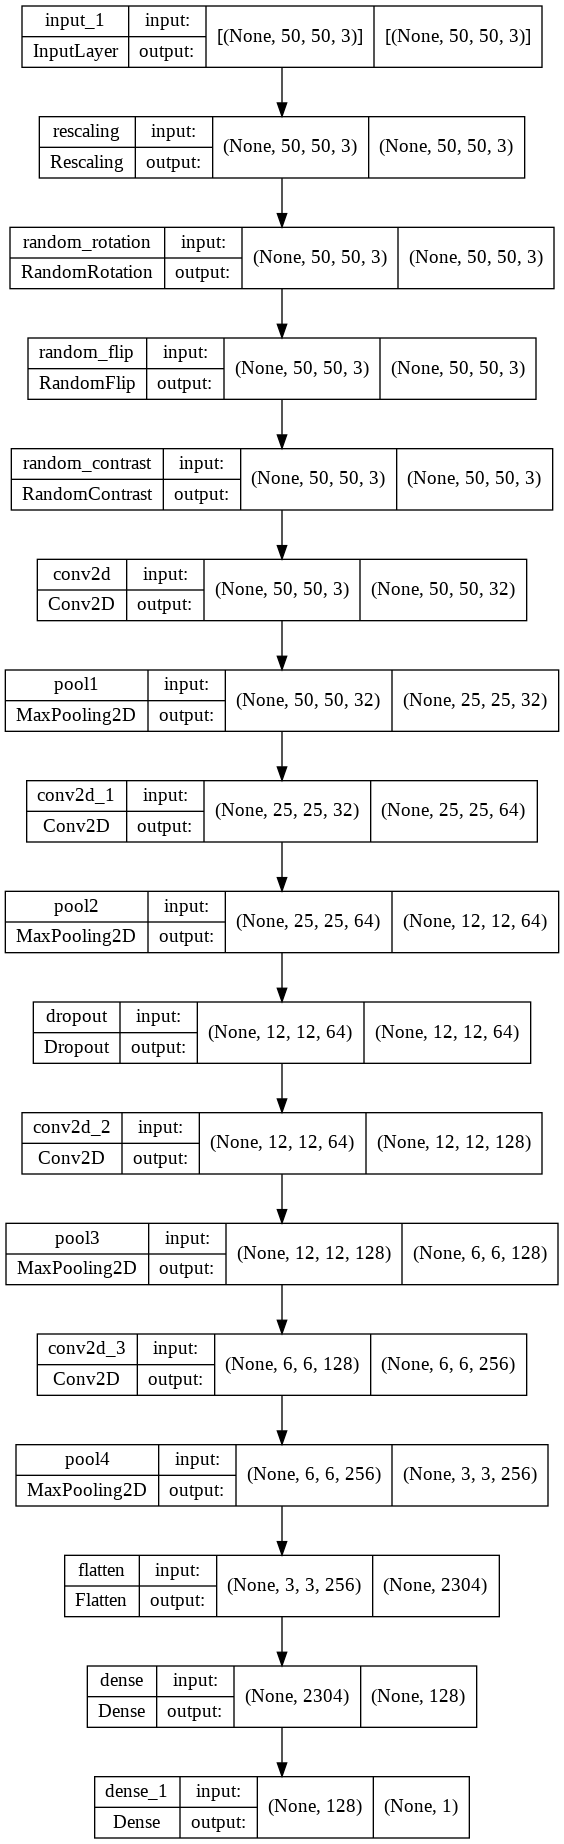

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.4)(x)
    x = layers.RandomFlip(mode="horizontal_and_vertical")(x)
    x = layers.RandomContrast(.01,.5)(x)

    # Entry block
    x = Conv2D(32, 3, activation='relu', padding='same')(x)                
    x = MaxPooling2D((2,2), name='pool1')(x)  

    x = Conv2D(64, 3, activation='relu', padding='same')(x)                
    x = MaxPooling2D((2,2), name='pool2')(x)
    x = layers.Dropout(0.25)(x)
    
    x = Conv2D(128, 3, activation='relu', padding='same')(x)                
    x = MaxPooling2D((2,2), name='pool3')(x)


    x = Conv2D(256, 3, activation='relu', padding='same')(x)                
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)     
    x = Dense(128, activation='relu')(x)    

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model11 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model11, show_shapes=True)


In [11]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 21/model21.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 21/Model21"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [12]:
model11.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])
model_11 = model11.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=1, validation_data = test_ds)

Epoch 1/100
128/128 [==============================] - 308s 2s/step - loss: 0.5431 - accuracy: 0.7200 - recall: 0.6264 - val_loss: 0.5789 - val_accuracy: 0.7318 - val_recall: 0.8332 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 34s 259ms/step - loss: 0.4532 - accuracy: 0.7979 - recall: 0.7692 - val_loss: 0.4591 - val_accuracy: 0.7895 - val_recall: 0.7723 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 34s 260ms/step - loss: 0.4438 - accuracy: 0.8046 - recall: 0.7805 - val_loss: 0.6050 - val_accuracy: 0.7252 - val_recall: 0.8743 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 34s 256ms/step - loss: 0.4350 - accuracy: 0.8106 - recall: 0.7923 - val_loss: 0.5295 - val_accuracy: 0.7469 - val_recall: 0.8304 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 34s 261ms/step - loss: 0.4340 - accuracy: 0.8075 - recall: 0.7855 - val_loss: 0.4254 - val_accuracy: 0.8116 - val_recall: 0.7953 - lr: 0.0010
Epoch 6/100
128/1

In [13]:
#model_eval11 = model_eval(model11)
model11.evaluate(train_ds)
model11.evaluate(test_ds)

67/67 [==============================] - 7s 92ms/step - loss: 0.3790 - accuracy: 0.8341 - recall: 0.7785


[0.37900006771087646, 0.8341478109359741, 0.7785340547561646]

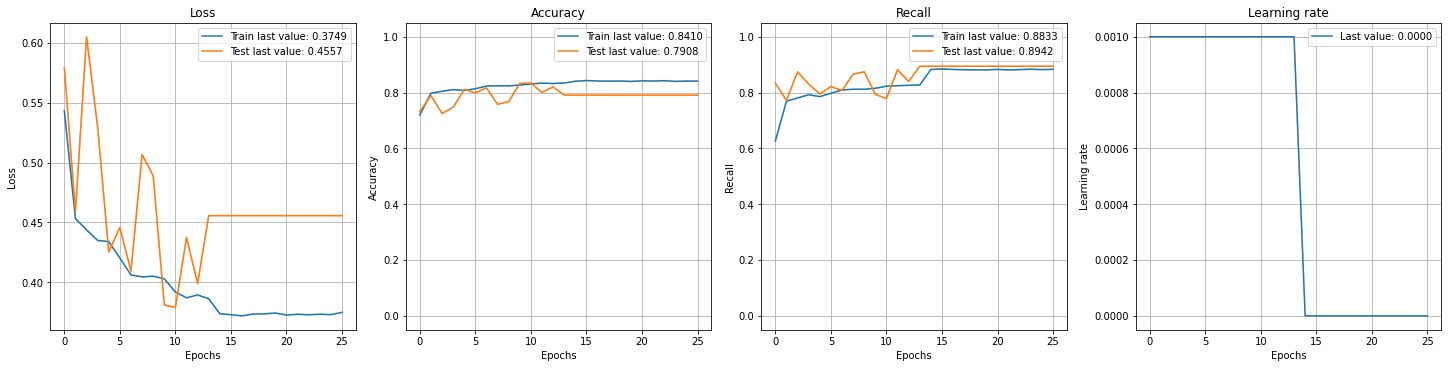

In [14]:
show_history(model_11)
plot_history(model_11, path="/content/drive/Othercomputers/My Computer/final project/Model 21/model21.png")
plt.close()

## Model 12

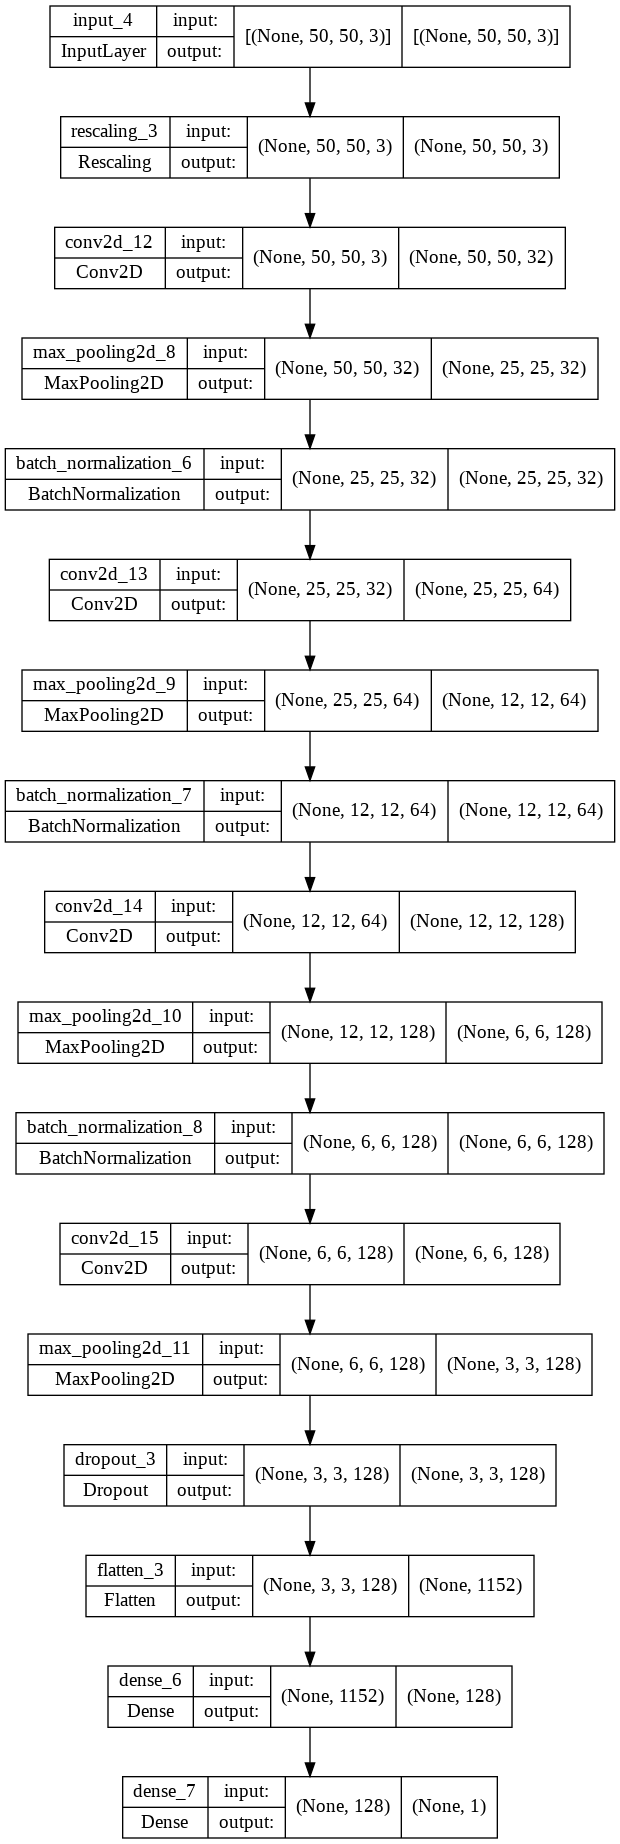

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)

    # Entry block
    x = Conv2D(32, (3,3), padding="same", activation='relu')(x)
    x = MaxPooling2D(2)(x)

    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3),  padding="same", activation='relu')(x)
    x = MaxPooling2D(2)(x)

    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3),  padding="same", activation='relu')(x)
    x = MaxPooling2D(2)(x)

    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding="same", activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(128, activation = "relu")(x)   

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model12 = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model12, show_shapes=True)


In [19]:
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/Othercomputers/My Computer/final project/Model 15/model15.h5",monitor= "val_loss", save_best_only=True )
log_dir = "/content/drive/Othercomputers/My Computer/final project/Model 15/Model15"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_rate,mod_checkpt,tensorboard_callback]

In [20]:
model12.compile(
    optimizer=keras.optimizers.SGD(1e-4, momentum=0.9),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])
model_12 = model12.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=1, validation_data = test_ds)

Epoch 1/100
128/128 [==============================] - 36s 266ms/step - loss: 0.5794 - accuracy: 0.7057 - recall_1: 0.6822 - val_loss: 0.6896 - val_accuracy: 0.5332 - val_recall_1: 0.9277 - lr: 1.0000e-04
Epoch 2/100
128/128 [==============================] - 37s 282ms/step - loss: 0.4932 - accuracy: 0.7780 - recall_1: 0.7434 - val_loss: 0.8081 - val_accuracy: 0.2985 - val_recall_1: 0.9995 - lr: 1.0000e-04
Epoch 3/100
128/128 [==============================] - 38s 287ms/step - loss: 0.4691 - accuracy: 0.7921 - recall_1: 0.7660 - val_loss: 0.7657 - val_accuracy: 0.5542 - val_recall_1: 0.9476 - lr: 1.0000e-04
Epoch 4/100
128/128 [==============================] - 38s 293ms/step - loss: 0.4549 - accuracy: 0.7986 - recall_1: 0.7767 - val_loss: 0.5561 - val_accuracy: 0.7518 - val_recall_1: 0.8403 - lr: 1.0000e-04
Epoch 5/100
128/128 [==============================] - 39s 301ms/step - loss: 0.4477 - accuracy: 0.8024 - recall_1: 0.7818 - val_loss: 0.4825 - val_accuracy: 0.7911 - val_recall_1:

In [21]:
#model_eval11 = model_eval(model11)
model12.evaluate(train_ds)
model12.evaluate(test_ds)

67/67 [==============================] - 7s 97ms/step - loss: 0.3904 - accuracy: 0.8324 - recall_1: 0.7804


[0.39044177532196045, 0.8324186205863953, 0.7803664803504944]

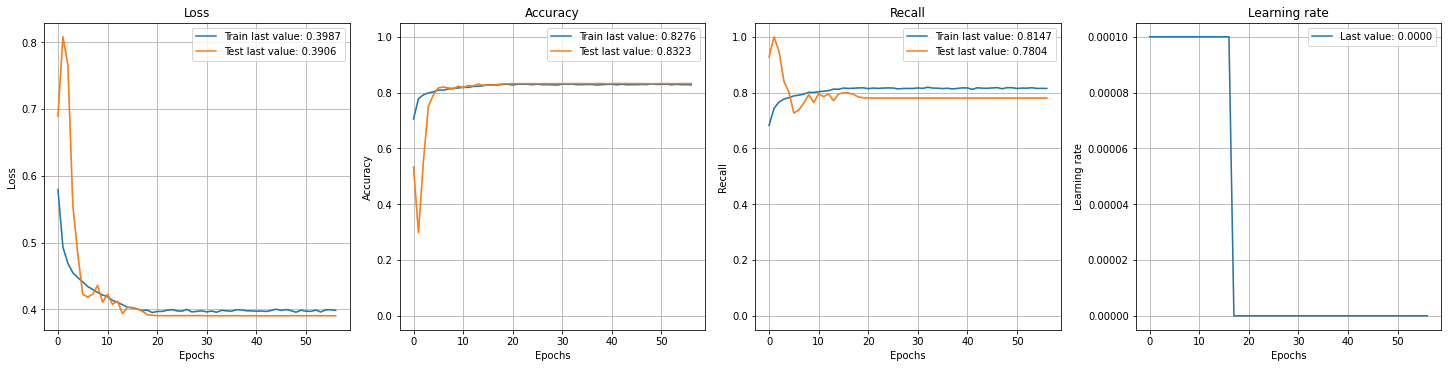

In [22]:
show_history(model_12)
plot_history(model_12, path="/content/drive/Othercomputers/My Computer/final project/Model 15/model15.png")
plt.close()

## Model 16

In [37]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomRotation(0.1),
    ]
)

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
base_model = tf.keras.applications.VGG16(input_shape=(50,50,3),include_top=False,weights="imagenet")

base_model.trainable = False

In [40]:
# Create new model on top
inputs = keras.Input(shape=(50, 50, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 255)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
epochs = 30
filepath = '/content/drive/Othercomputers/My Computer/final project/Model 16/densenet256x256_weighted.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_ds, epochs=epochs, callbacks=callbacks, verbose=1, validation_data = test_ds)

## Model 17

In [115]:
base_model.trainable = True
model.summary()

epochs = 100

filepath = '/content/drive/Othercomputers/My Computer/final project/Model 17/densenet256x256_weighted_tuned.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=test_ds)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                           

# Show Image

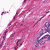

In [79]:
import torch
from torchvision import transforms
from PIL import Image
img = Image.open("/content/drive/Othercomputers/My Computer/final project/base_dir/val_dir/a_no_idc/10253_idx5_x1001_y1251_class0.png")
new_image = img.resize((50, 50))
new_image

In [107]:
x = preprocess_image(img_path="/content/drive/Othercomputers/My Computer/final project/base_dir/val_dir/a_no_idc/10253_idx5_x1001_y601_class0.png",model=model,resize=(50,50))

In [109]:
model.predict(x)

array([[-7.7946343]], dtype=float32)

In [112]:
activations = get_activations(model15,x)

input_2 (1, 50, 50, 3) 


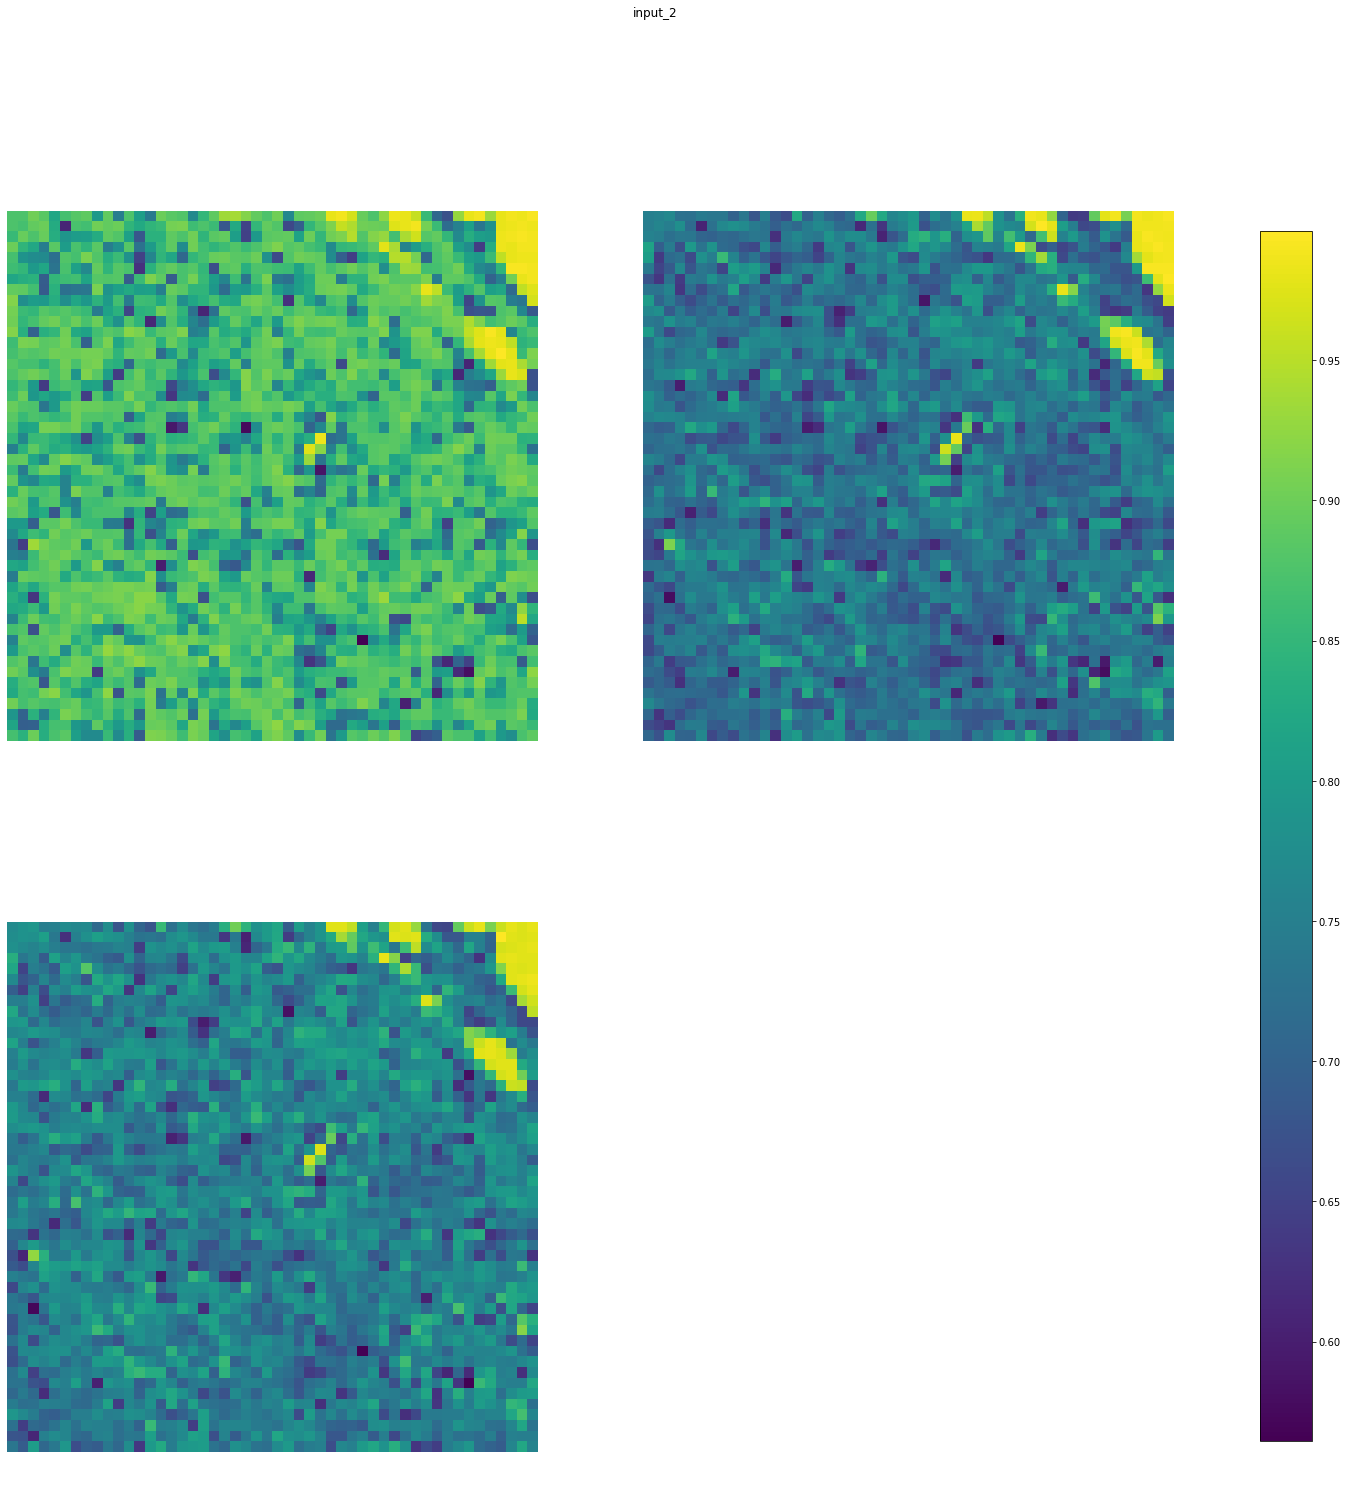

rescaling_1 (1, 50, 50, 3) 


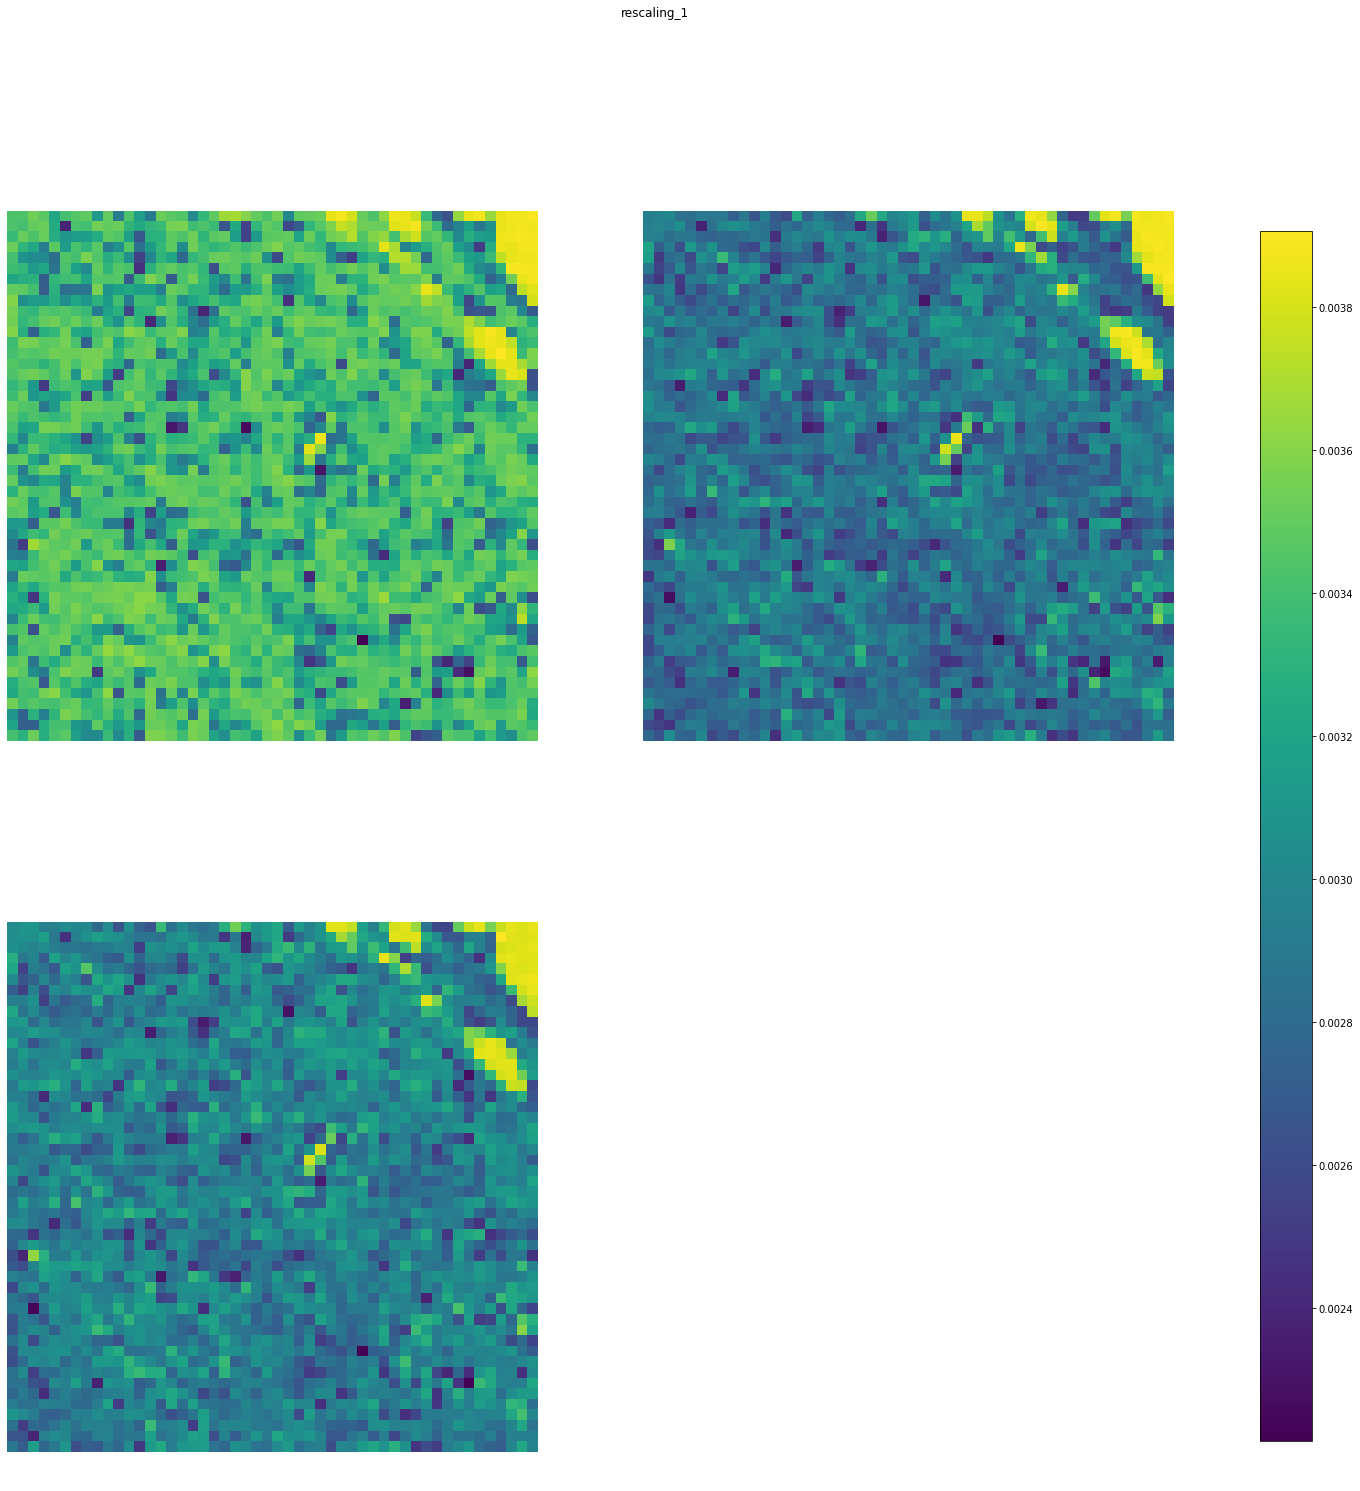

conv2d_4 (1, 50, 50, 32) 


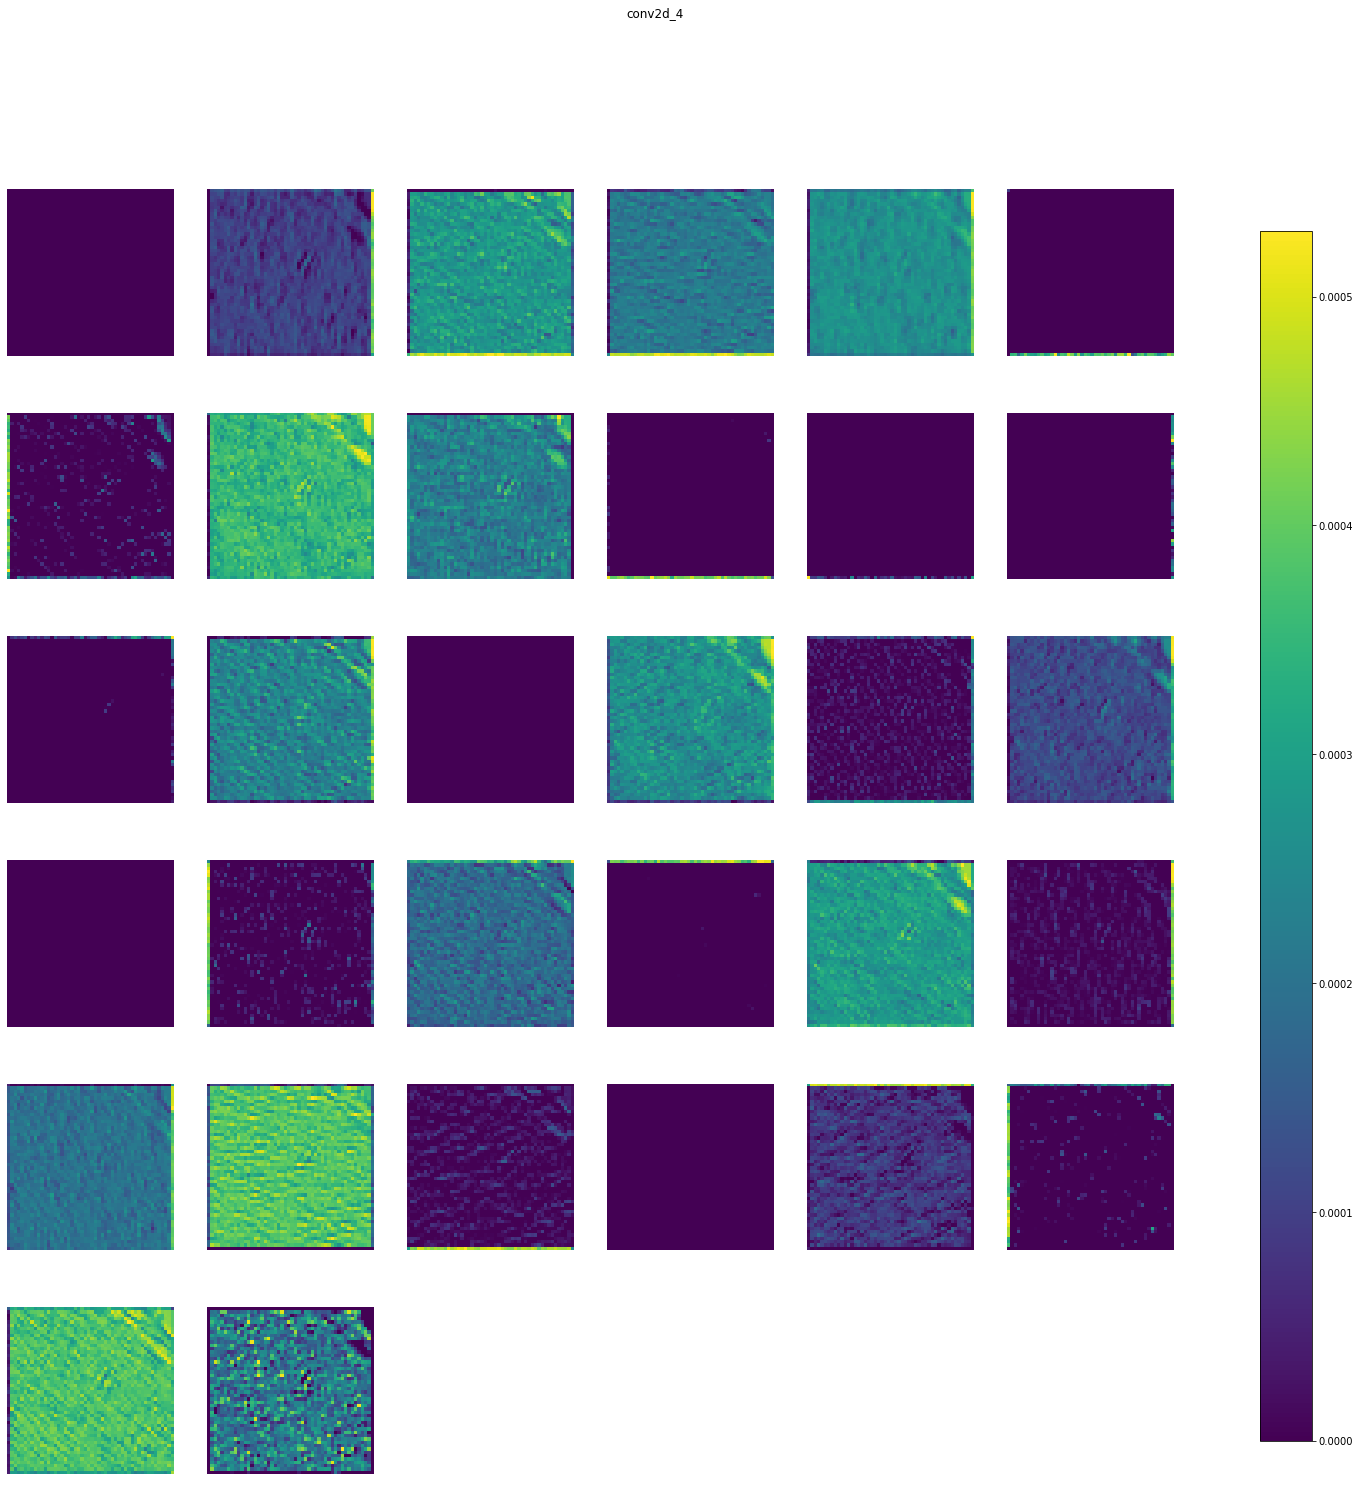

max_pooling2d (1, 25, 25, 32) 


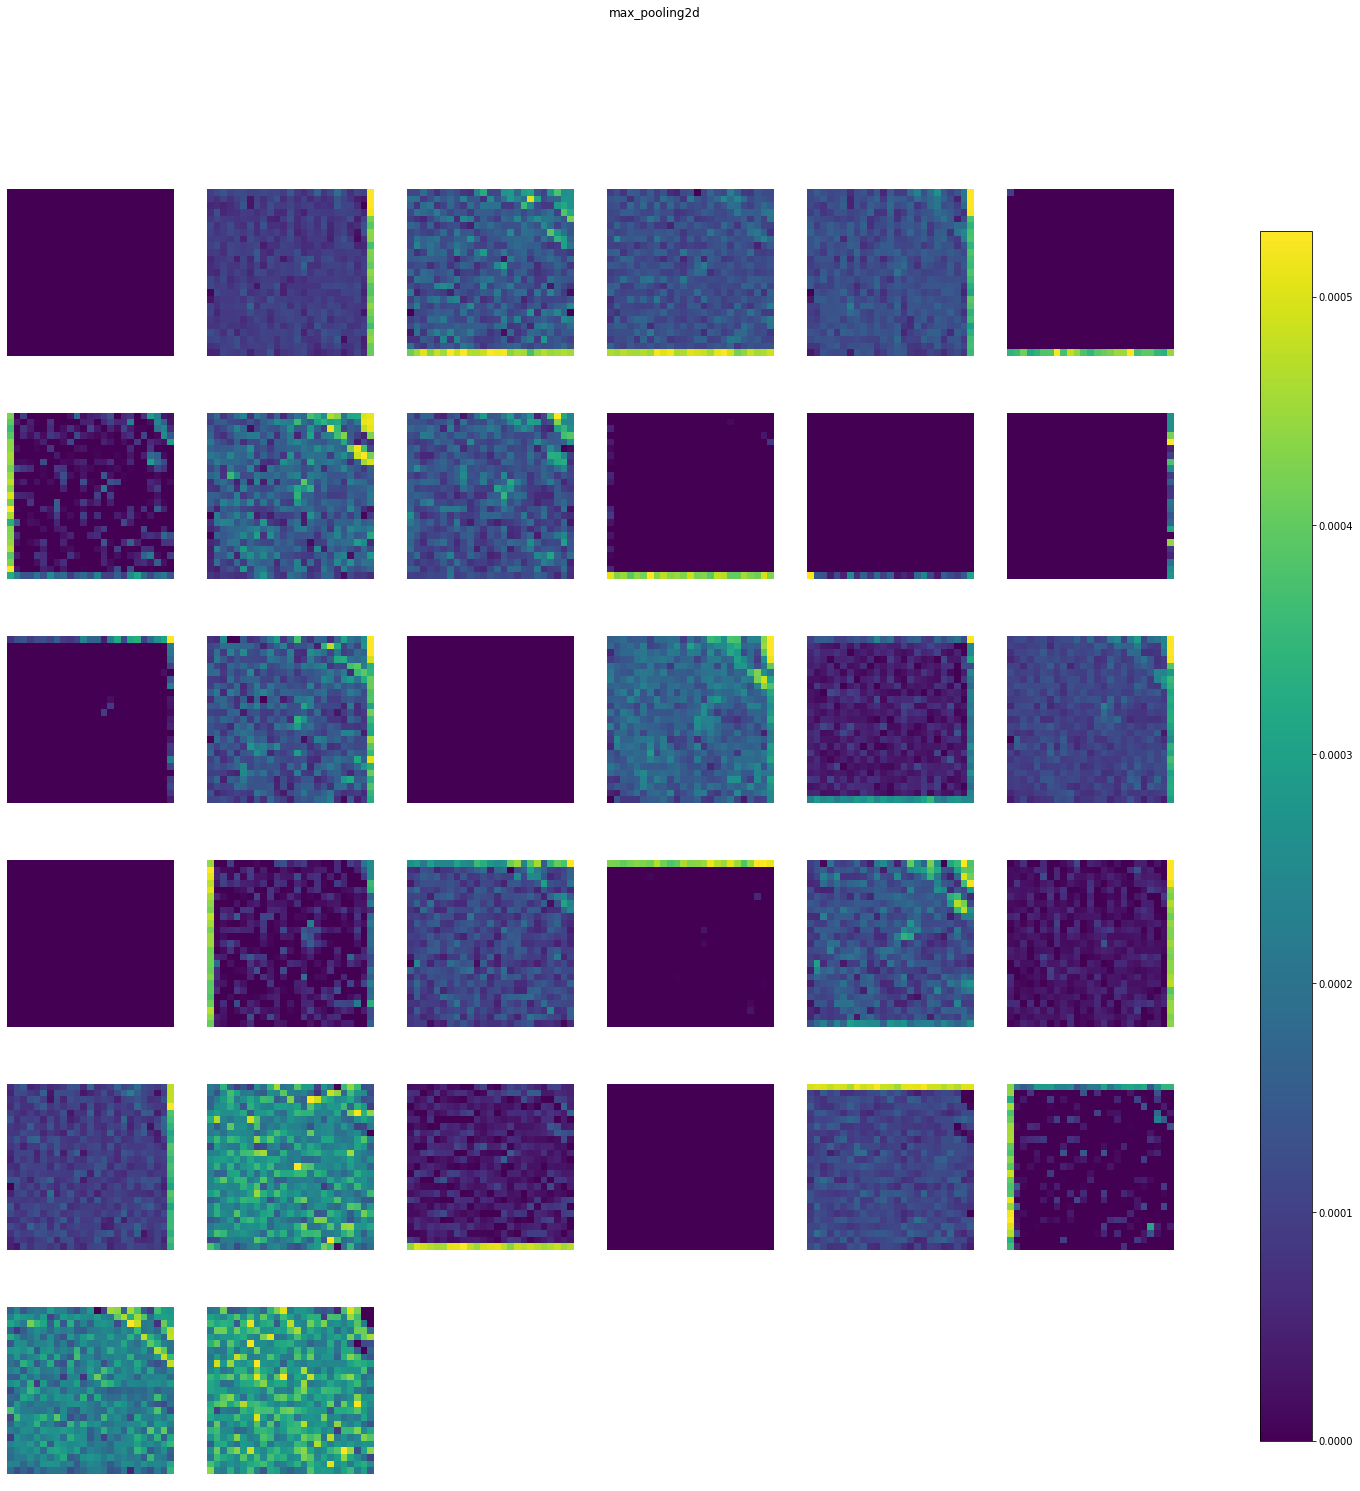

batch_normalization (1, 25, 25, 32) 


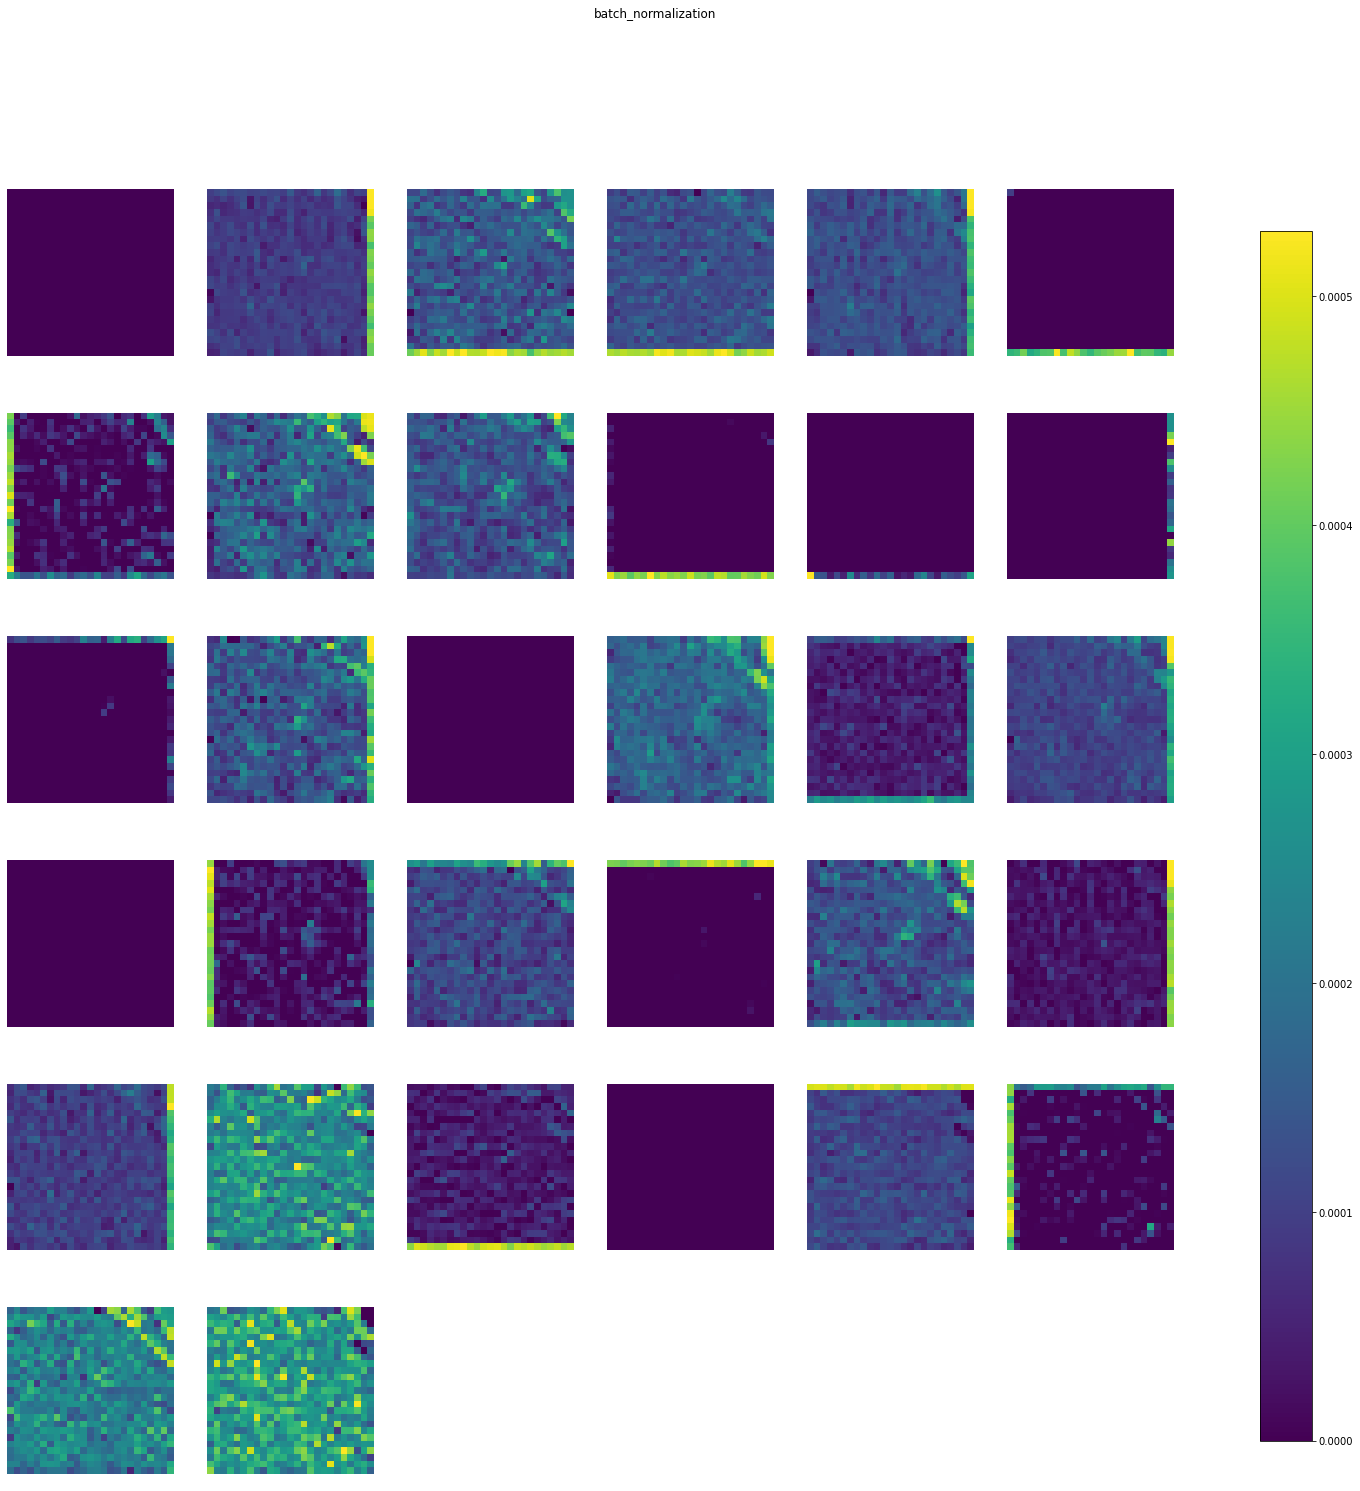

conv2d_5 (1, 25, 25, 64) 


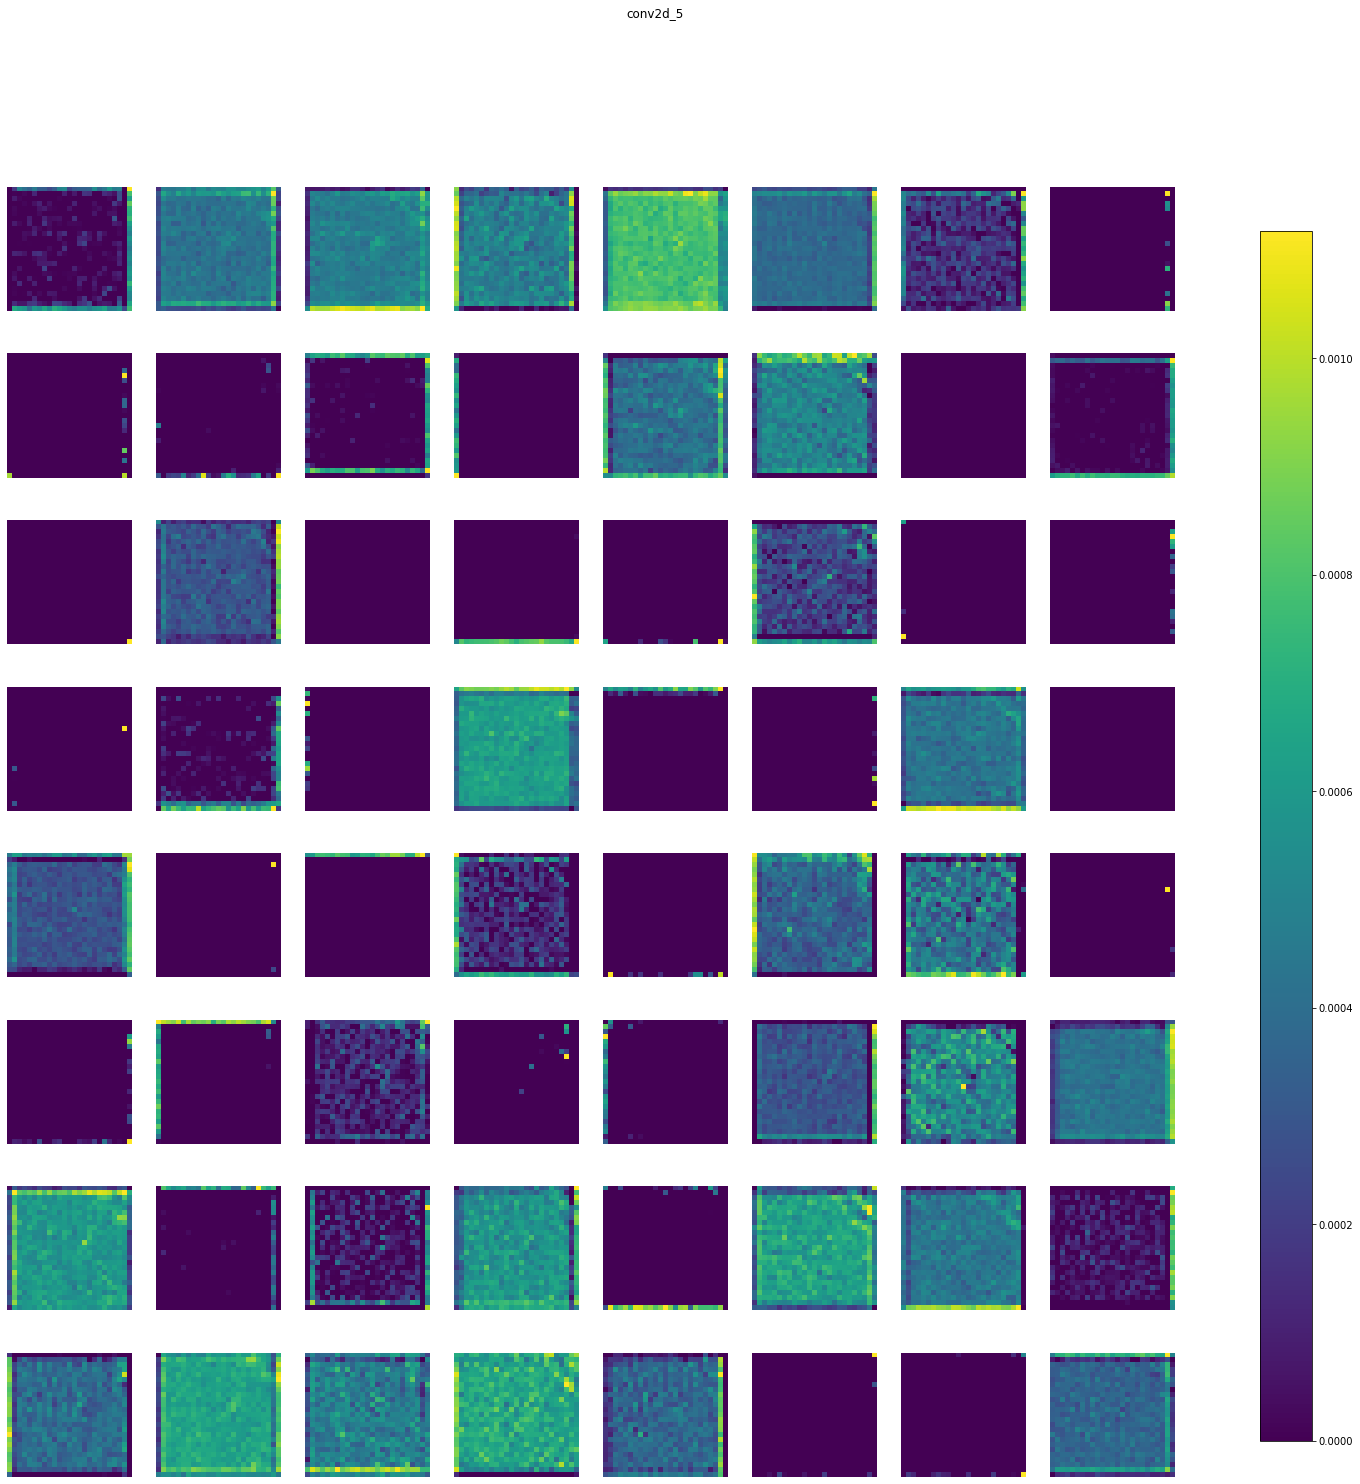

max_pooling2d_1 (1, 12, 12, 64) 


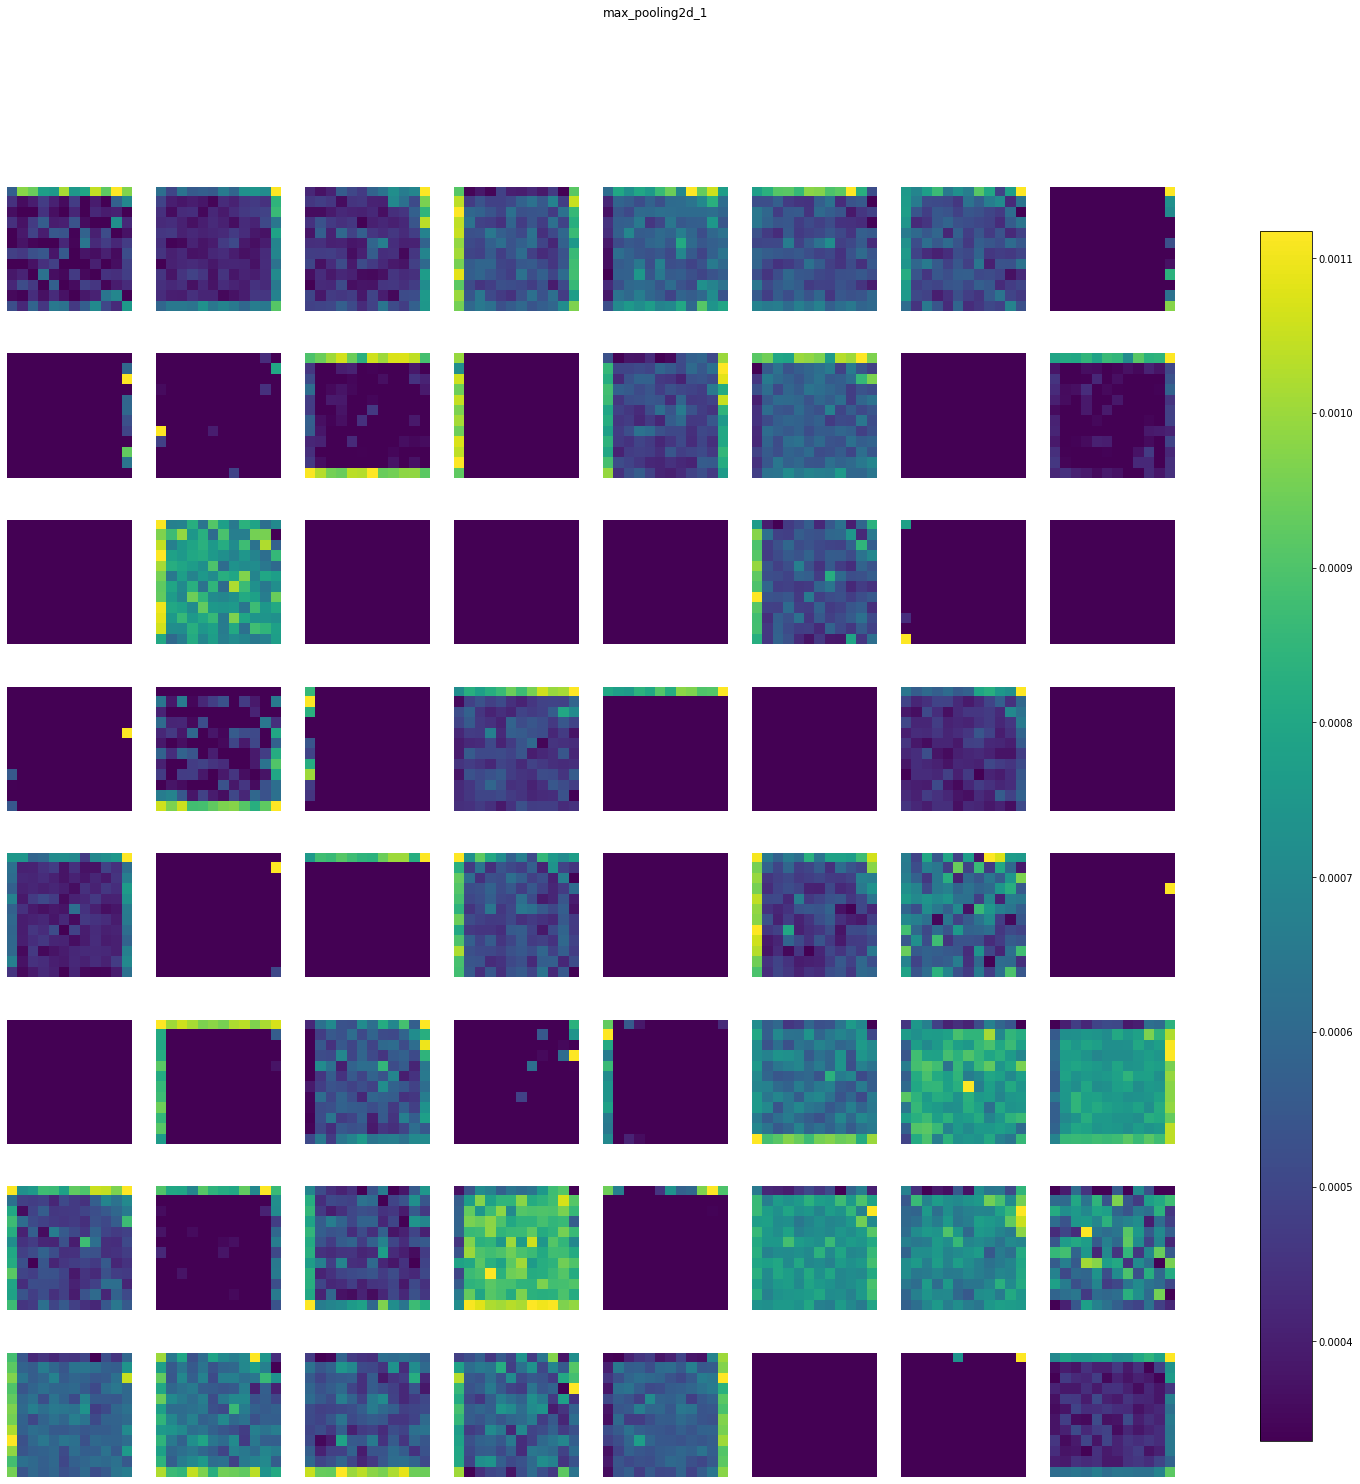

batch_normalization_1 (1, 12, 12, 64) 


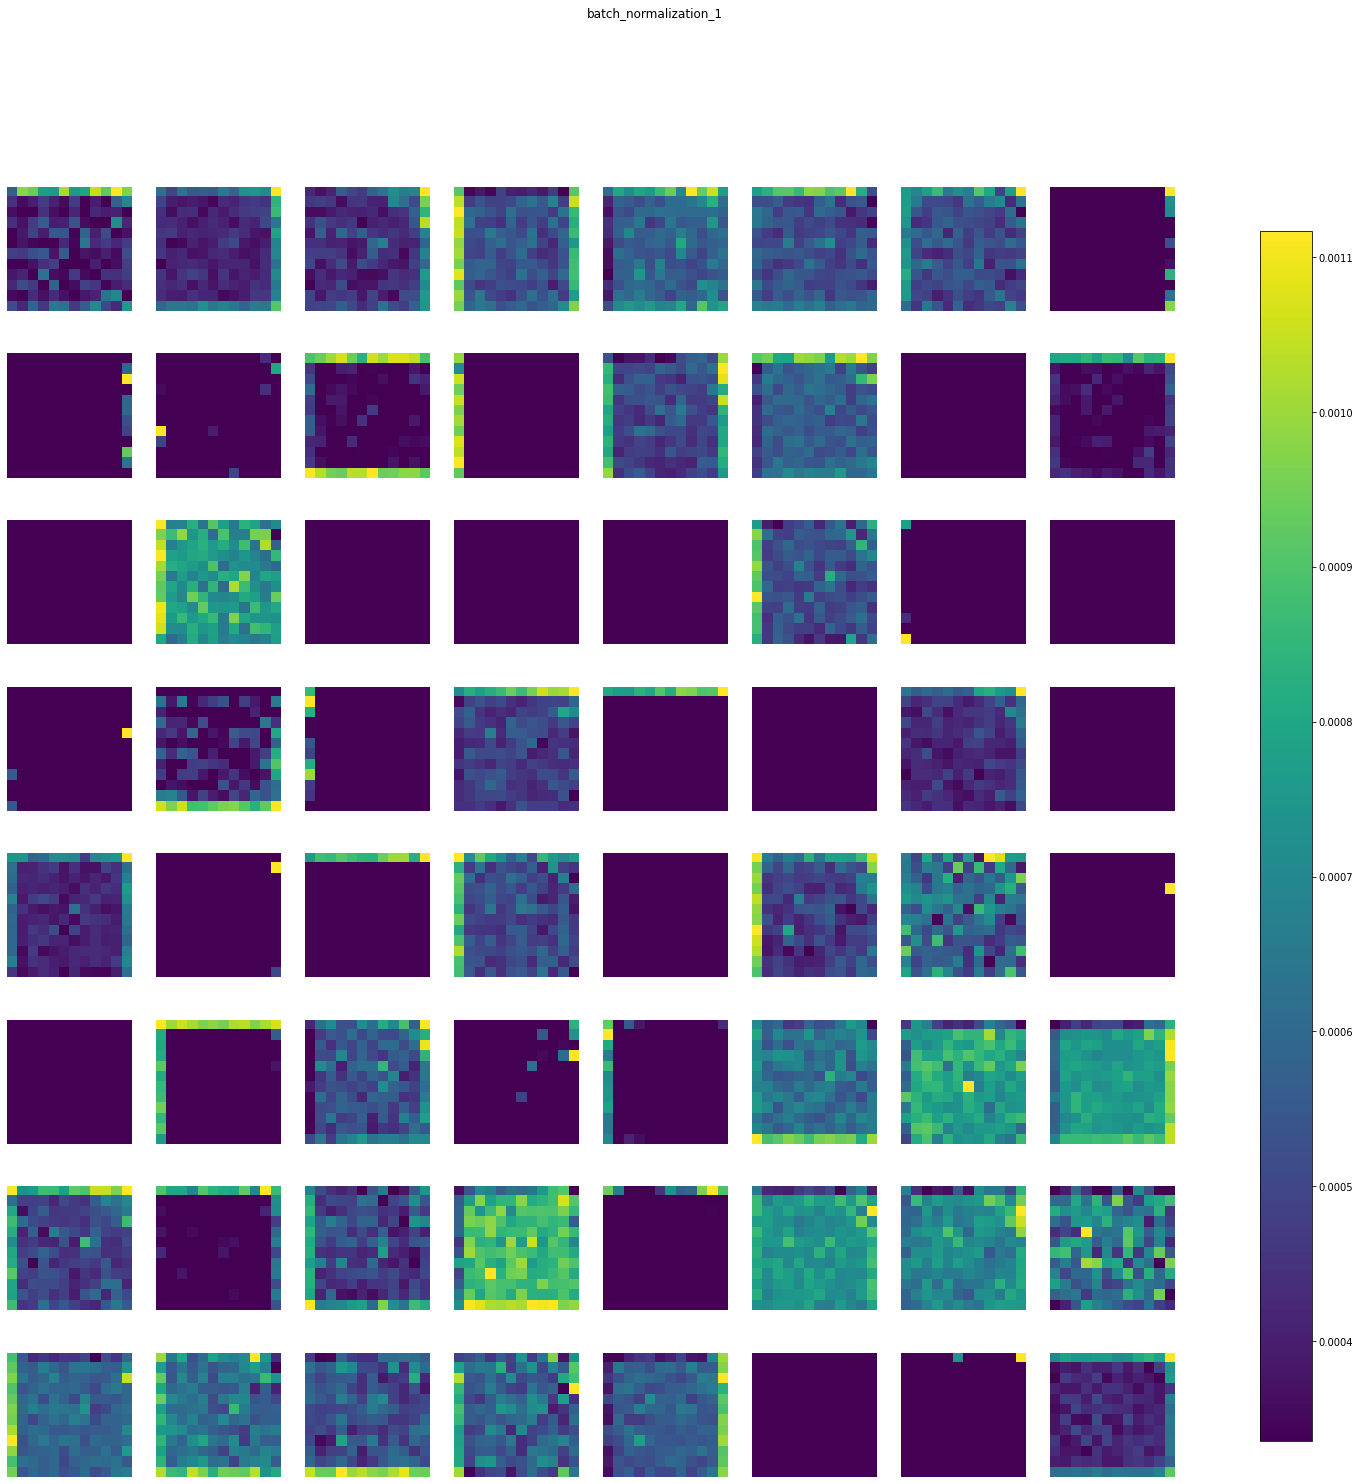

conv2d_6 (1, 12, 12, 128) 


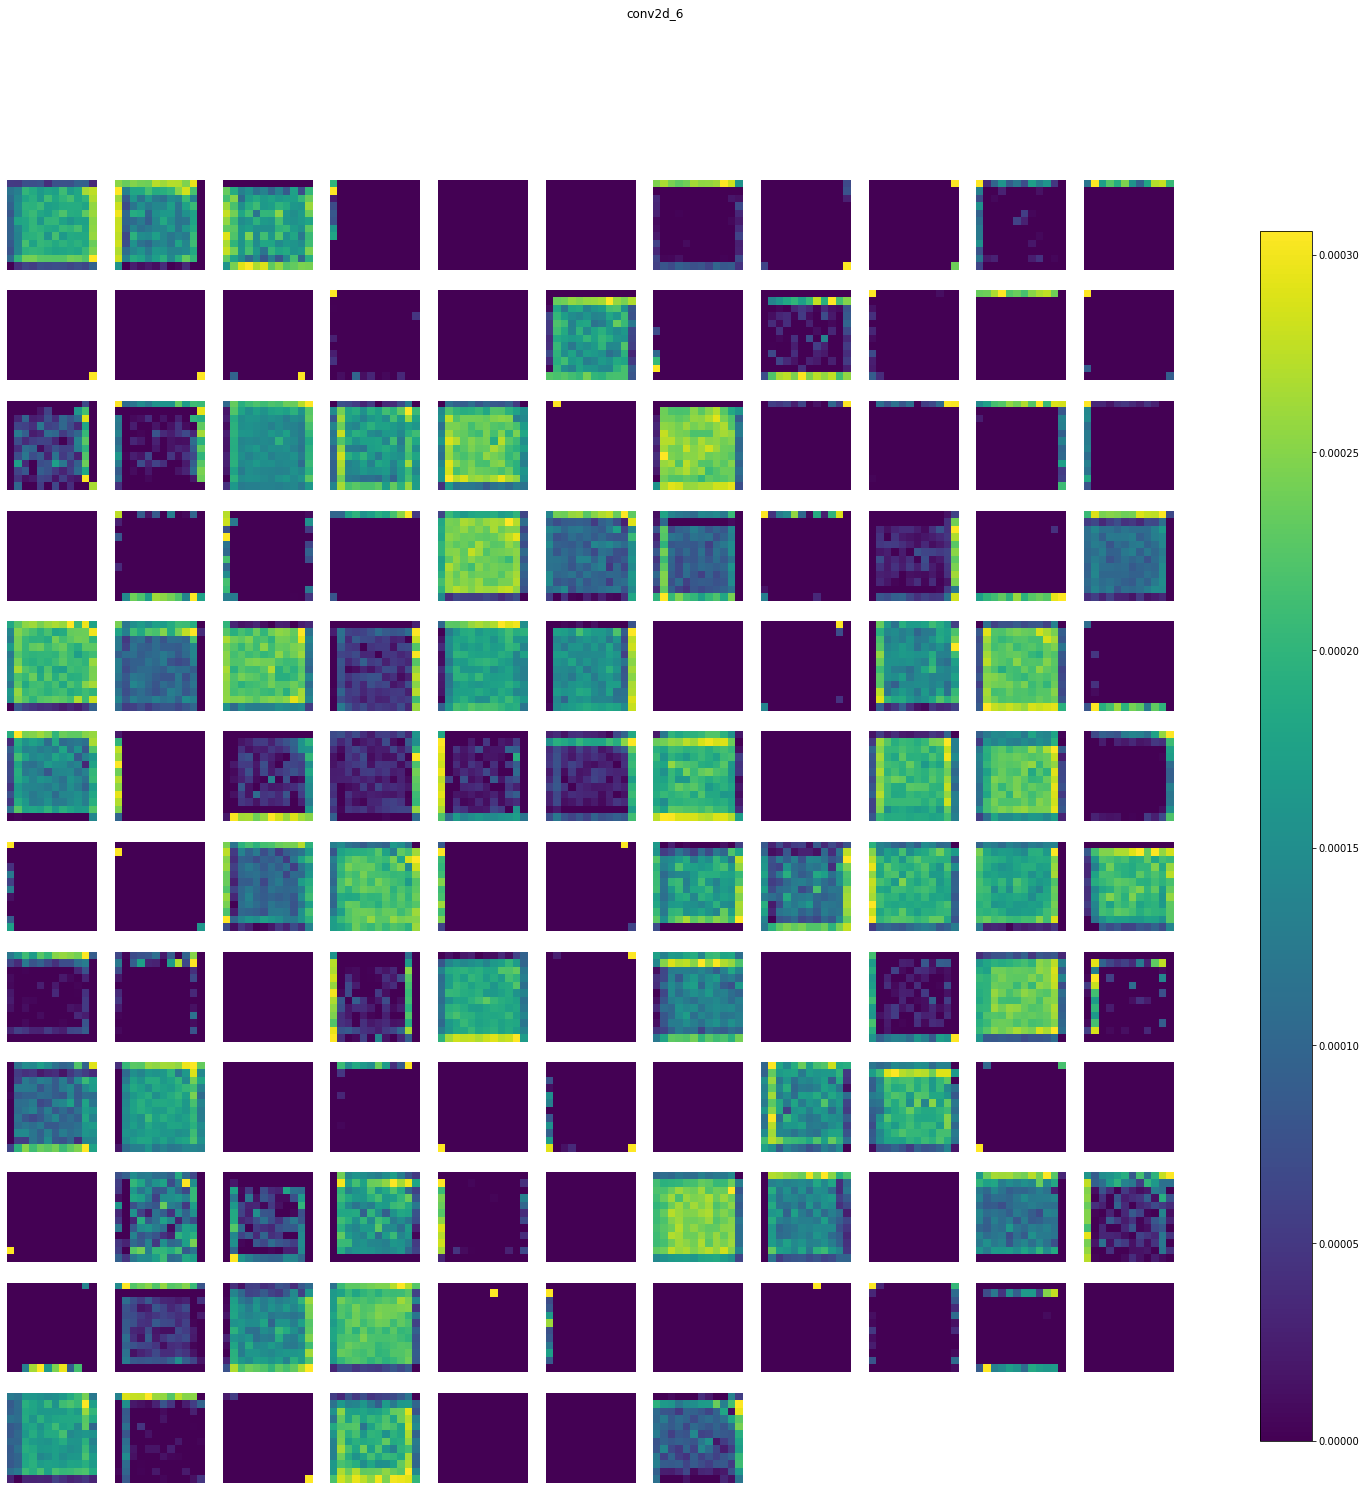

max_pooling2d_2 (1, 6, 6, 128) 


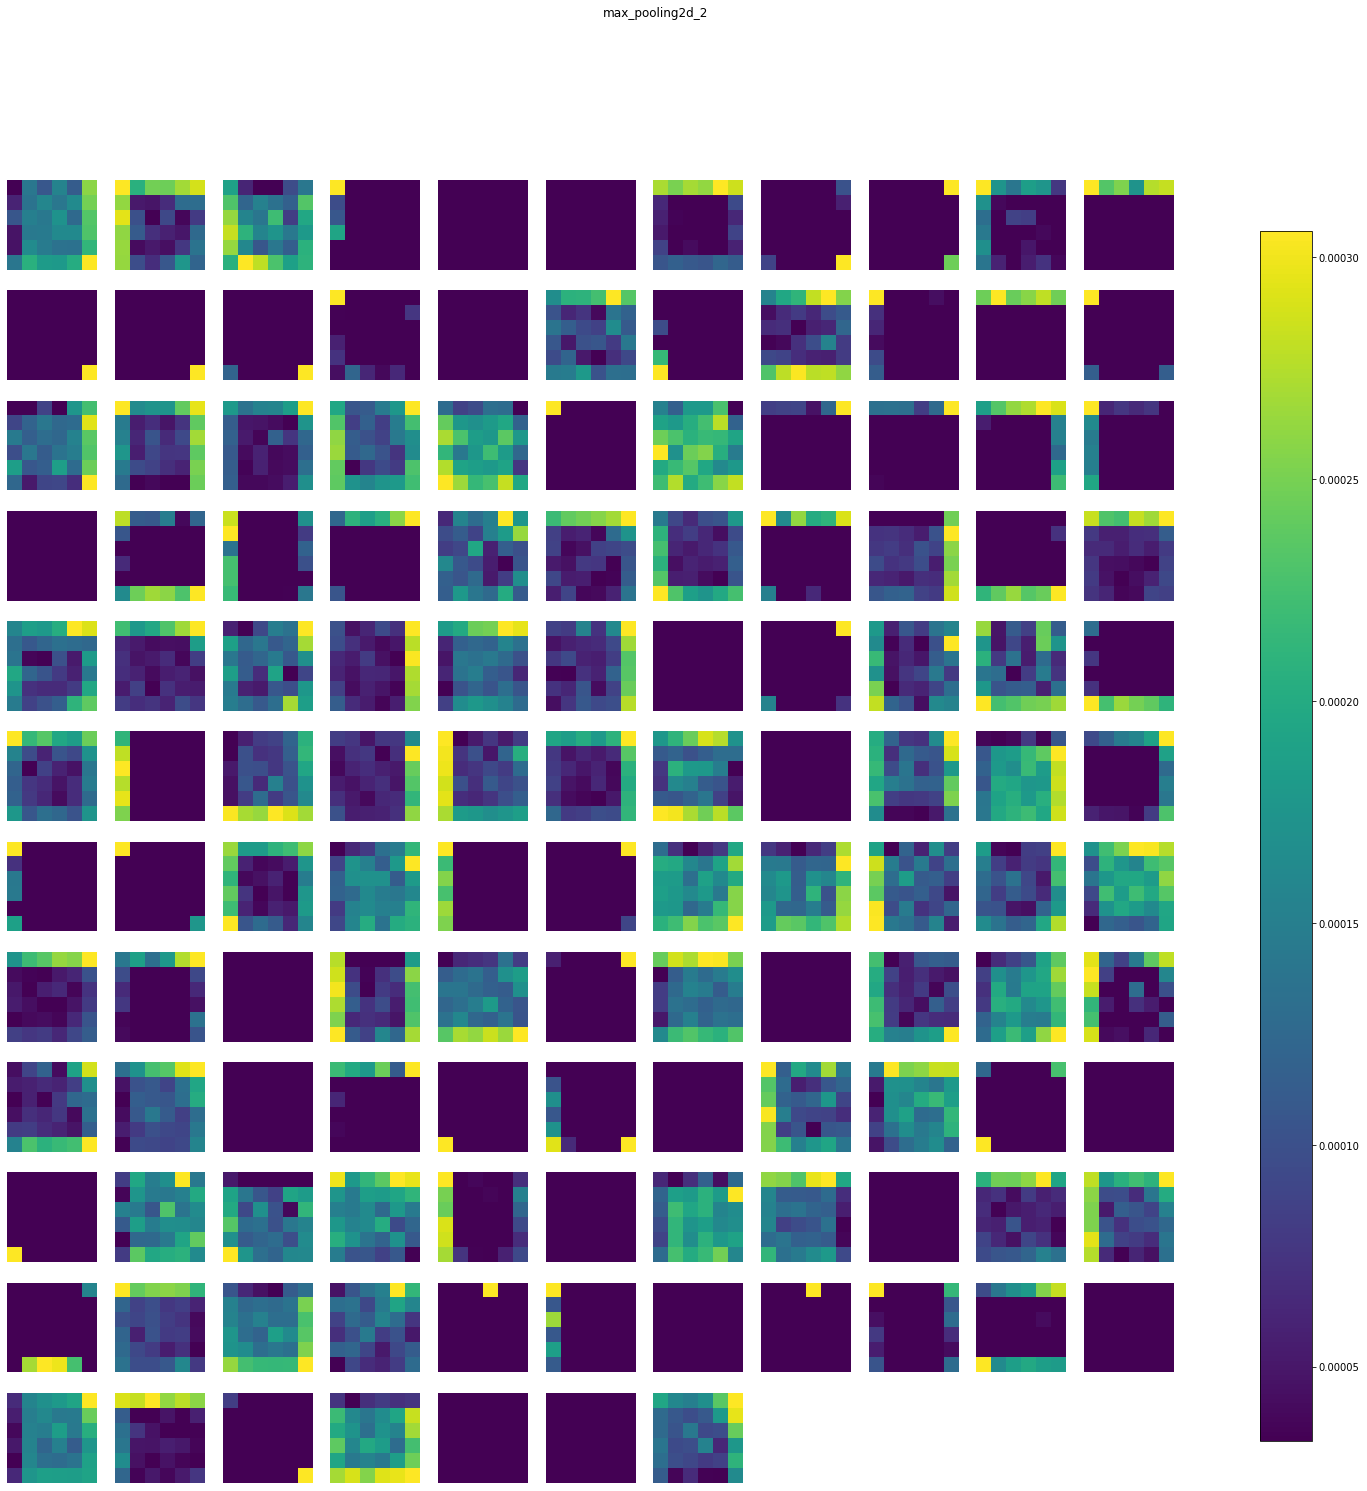

batch_normalization_2 (1, 6, 6, 128) 


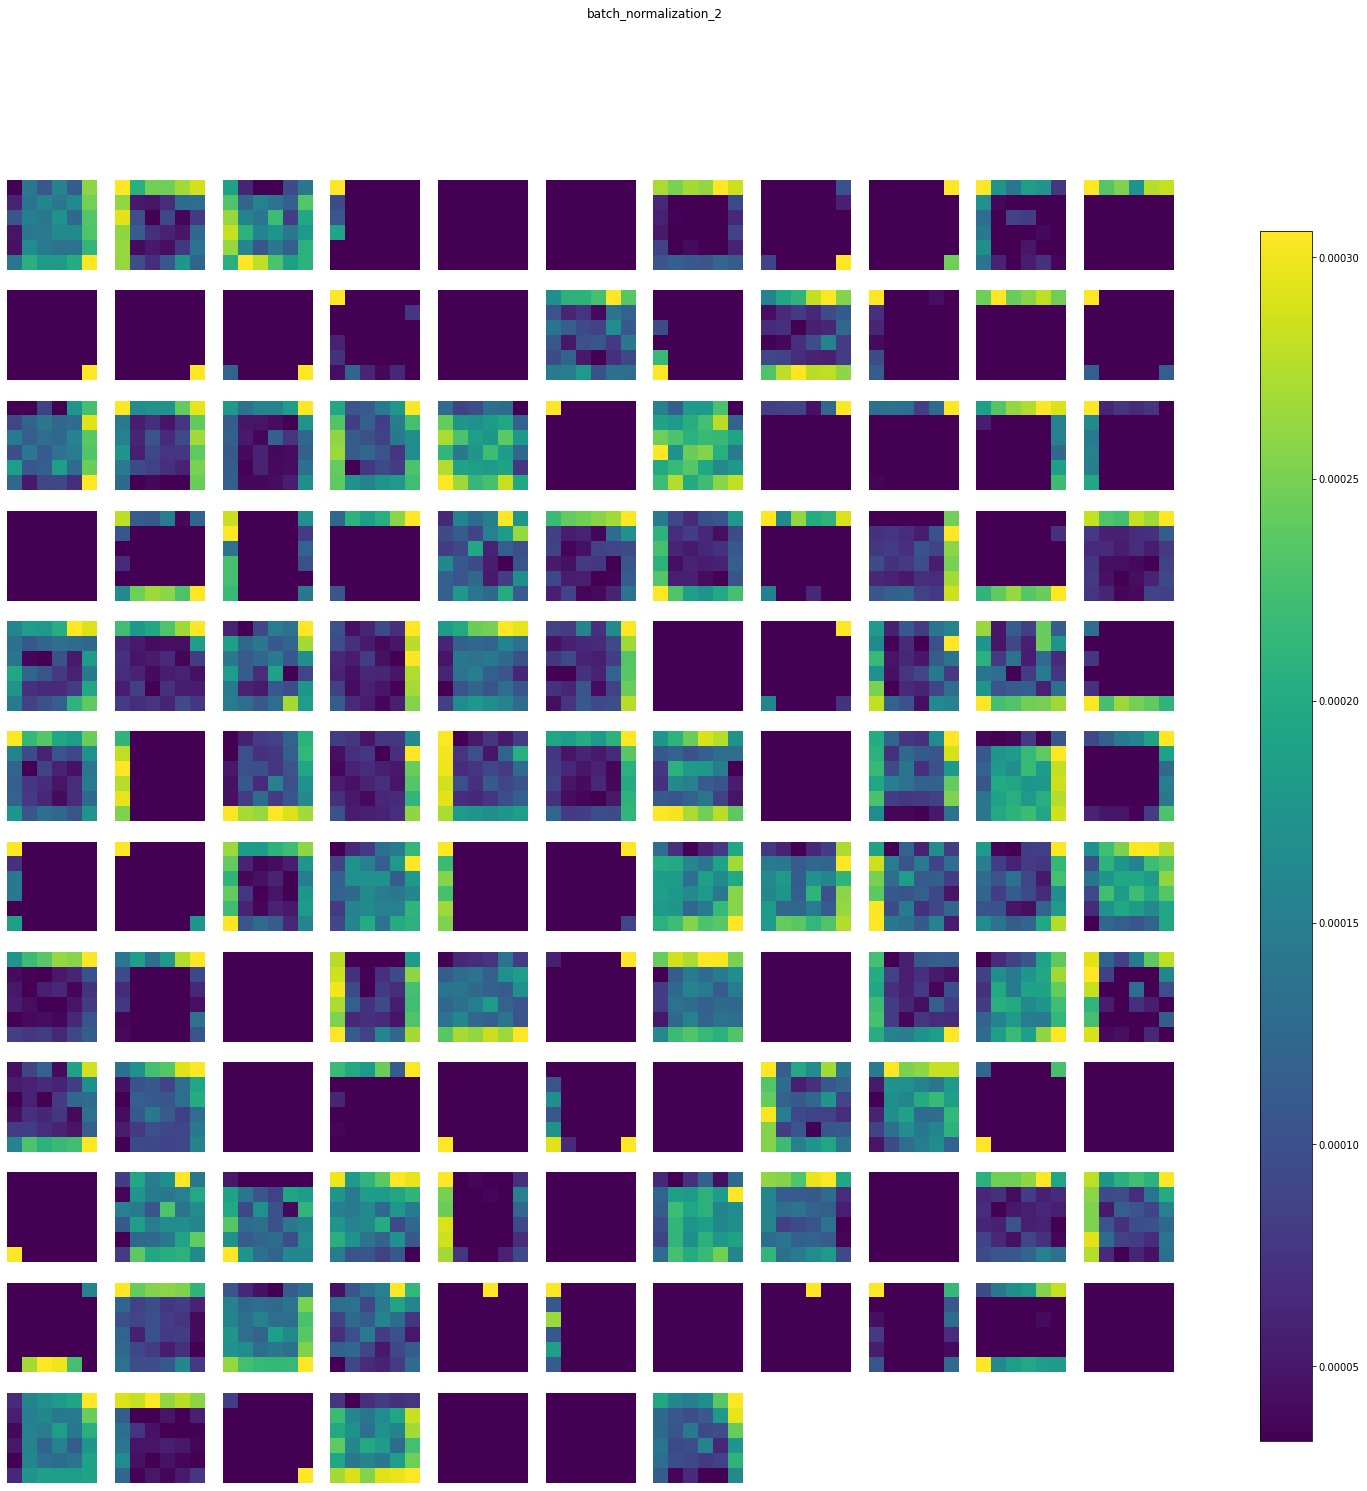

conv2d_7 (1, 6, 6, 128) 


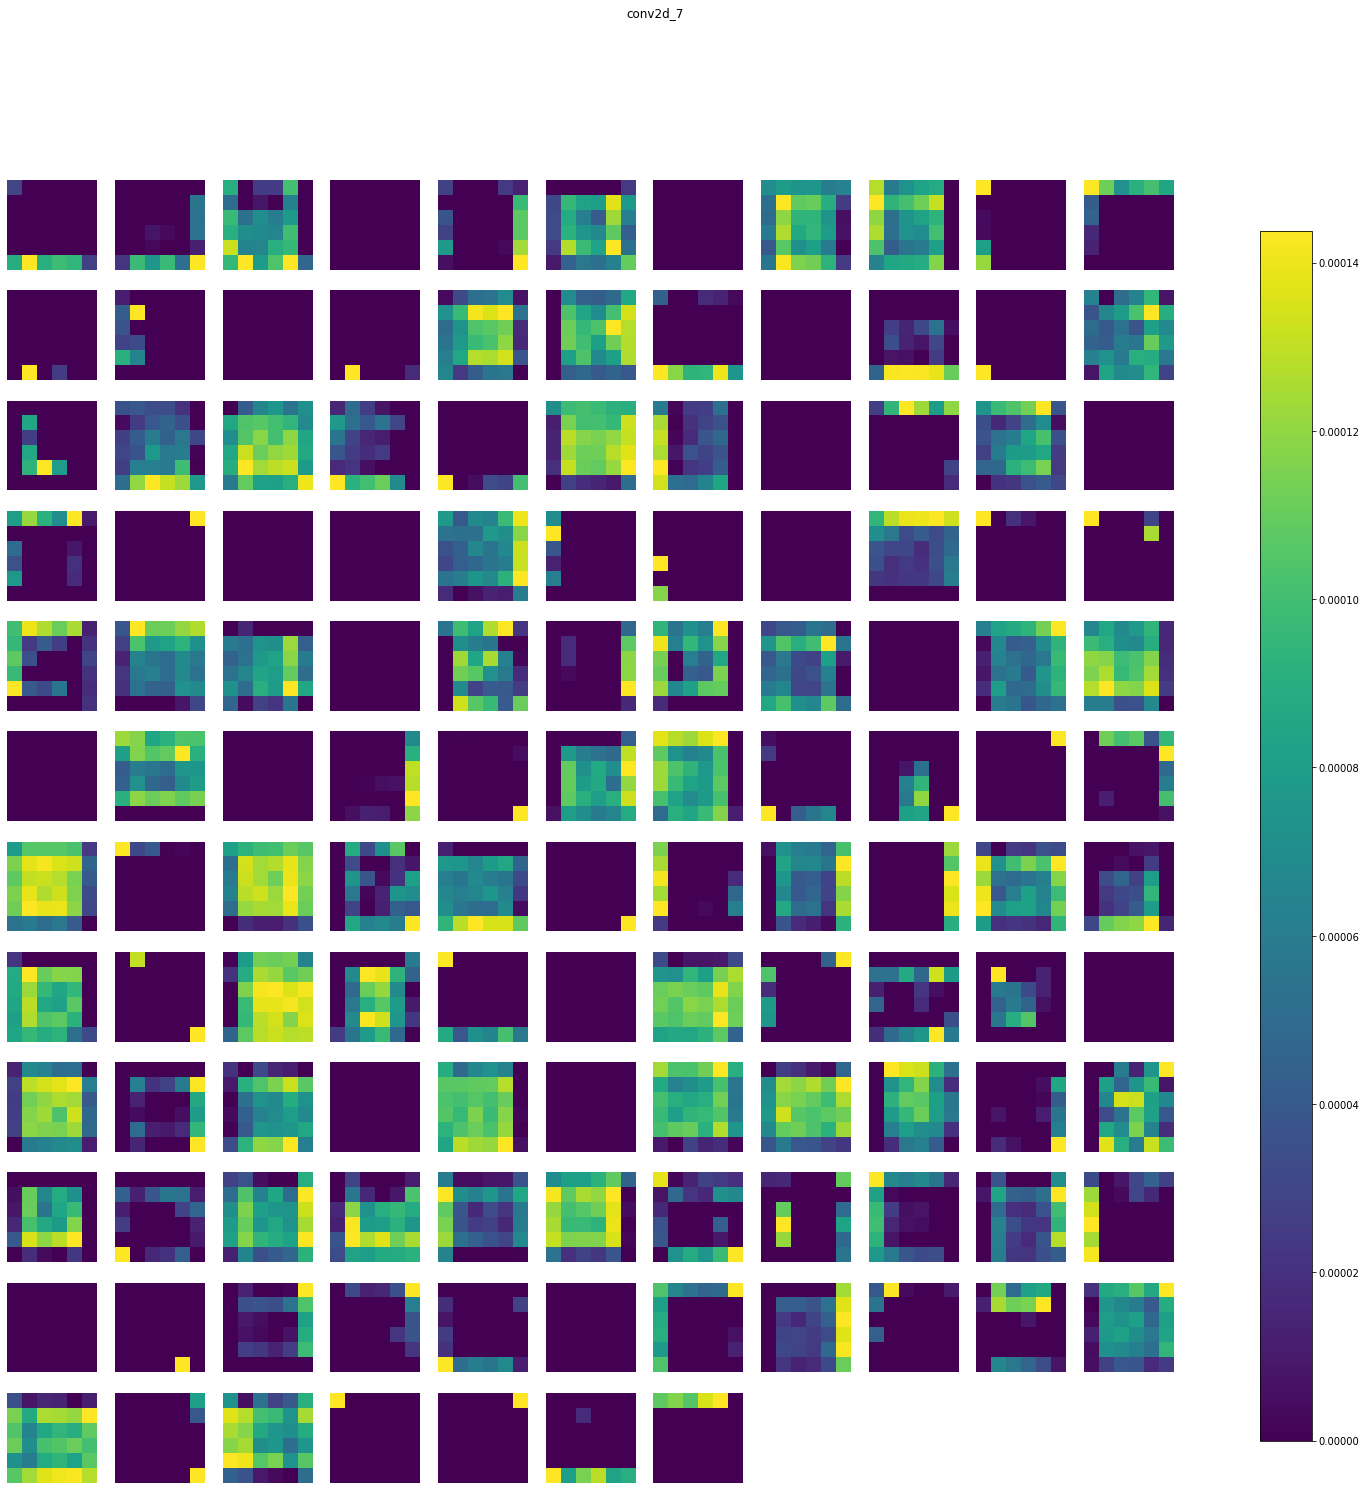

max_pooling2d_3 (1, 3, 3, 128) 


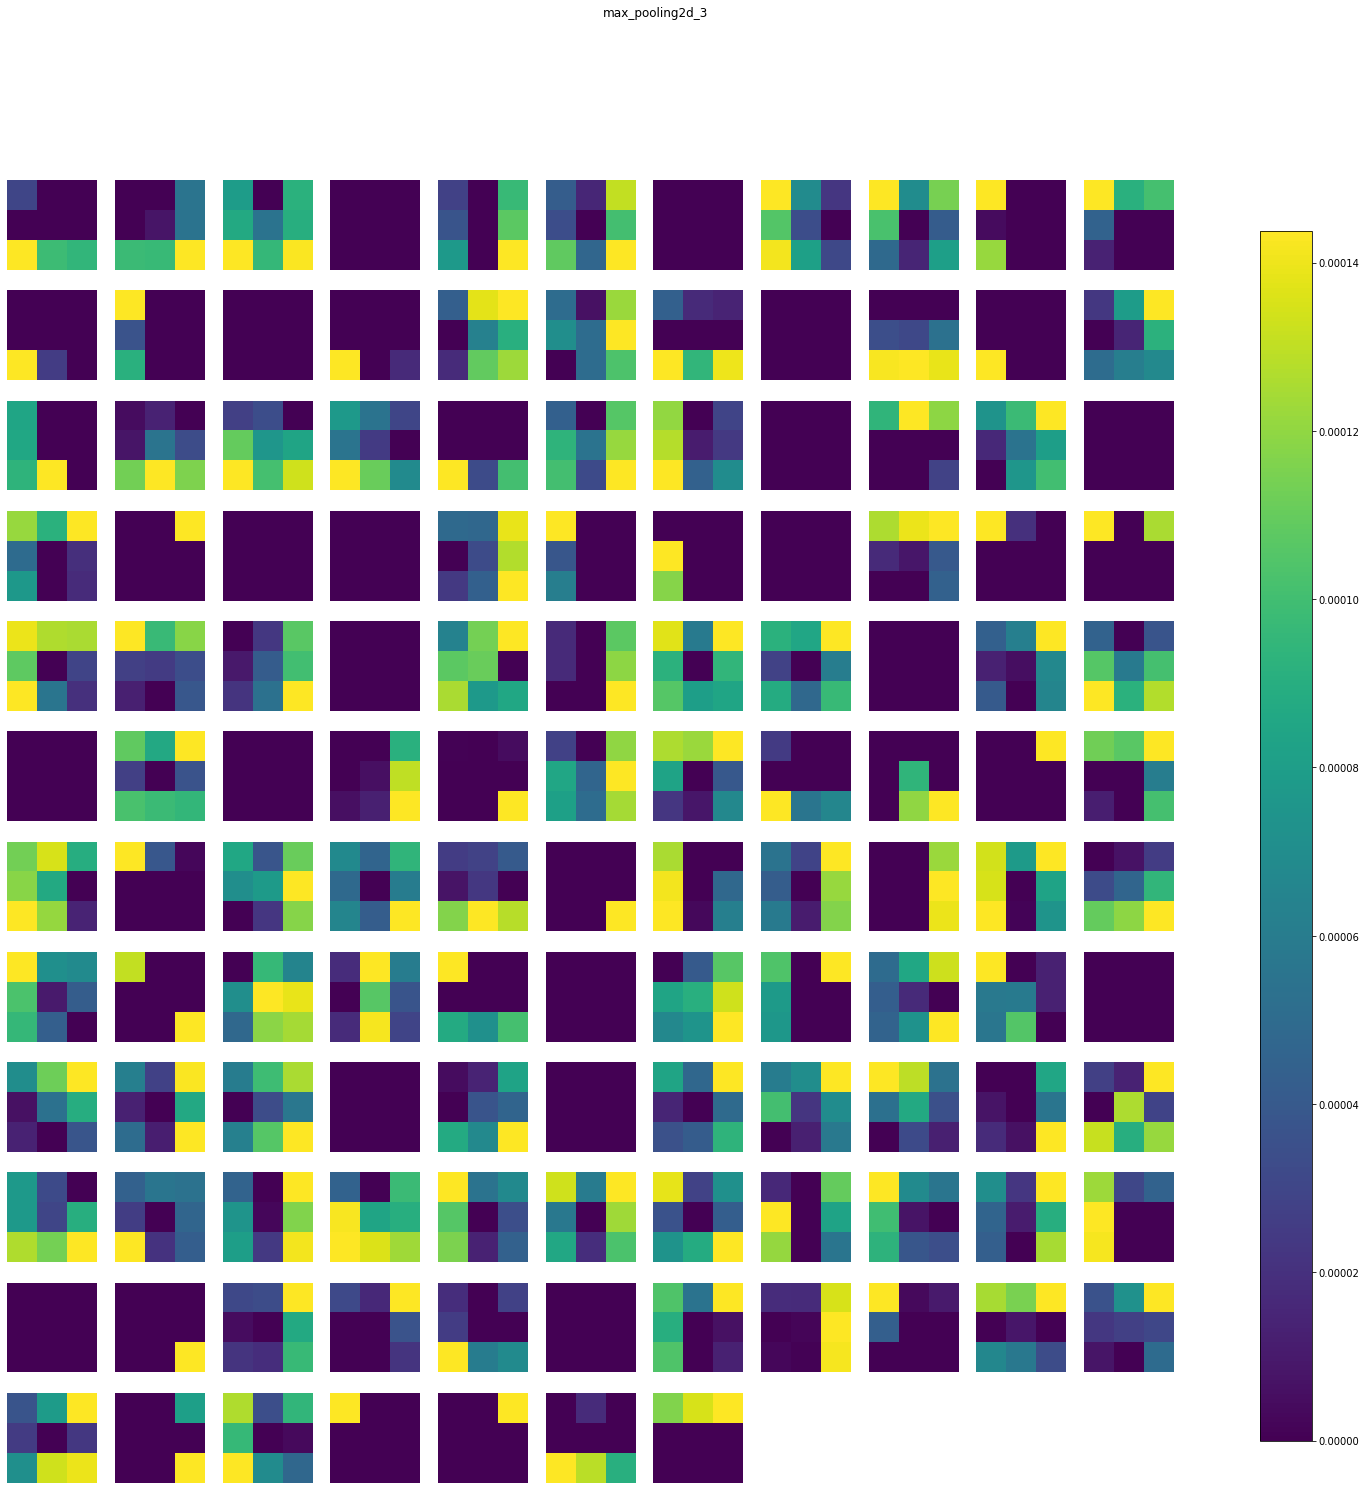

dropout_1 (1, 3, 3, 128) 


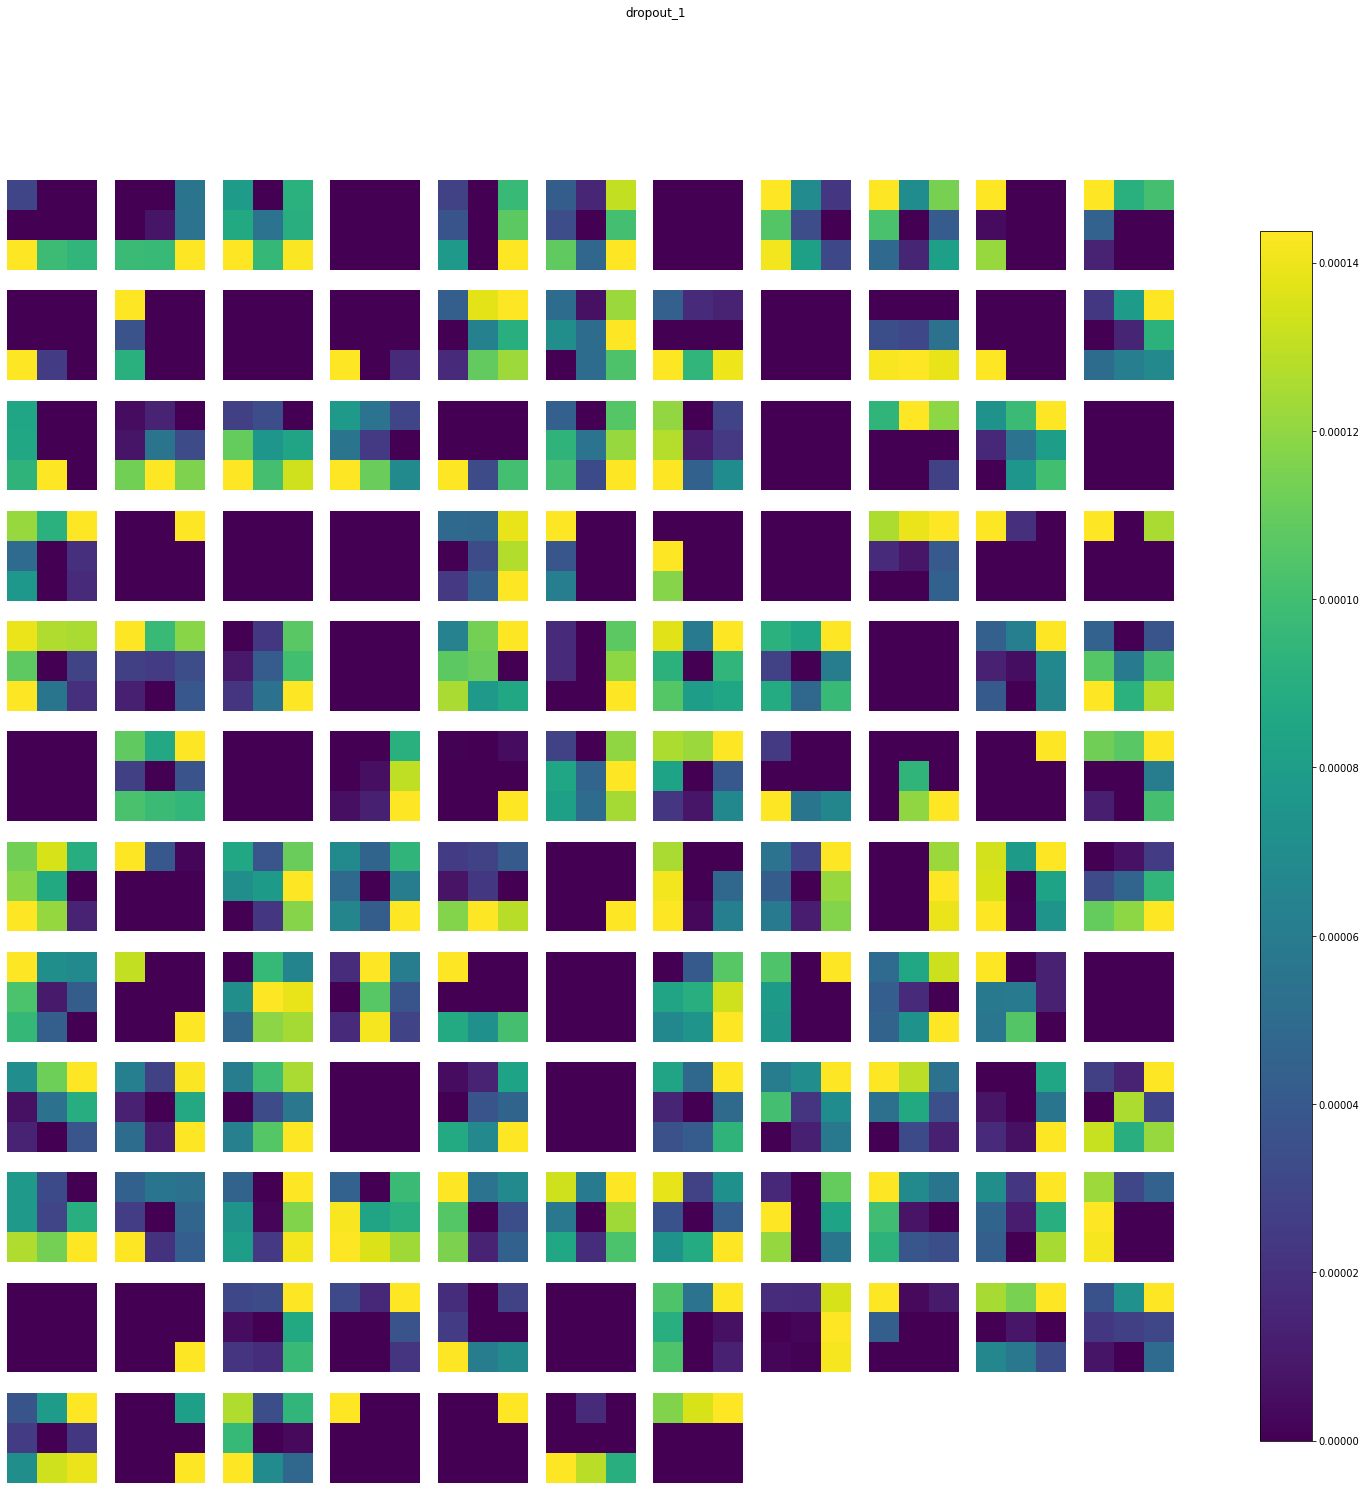

flatten_1 (1, 1152) 


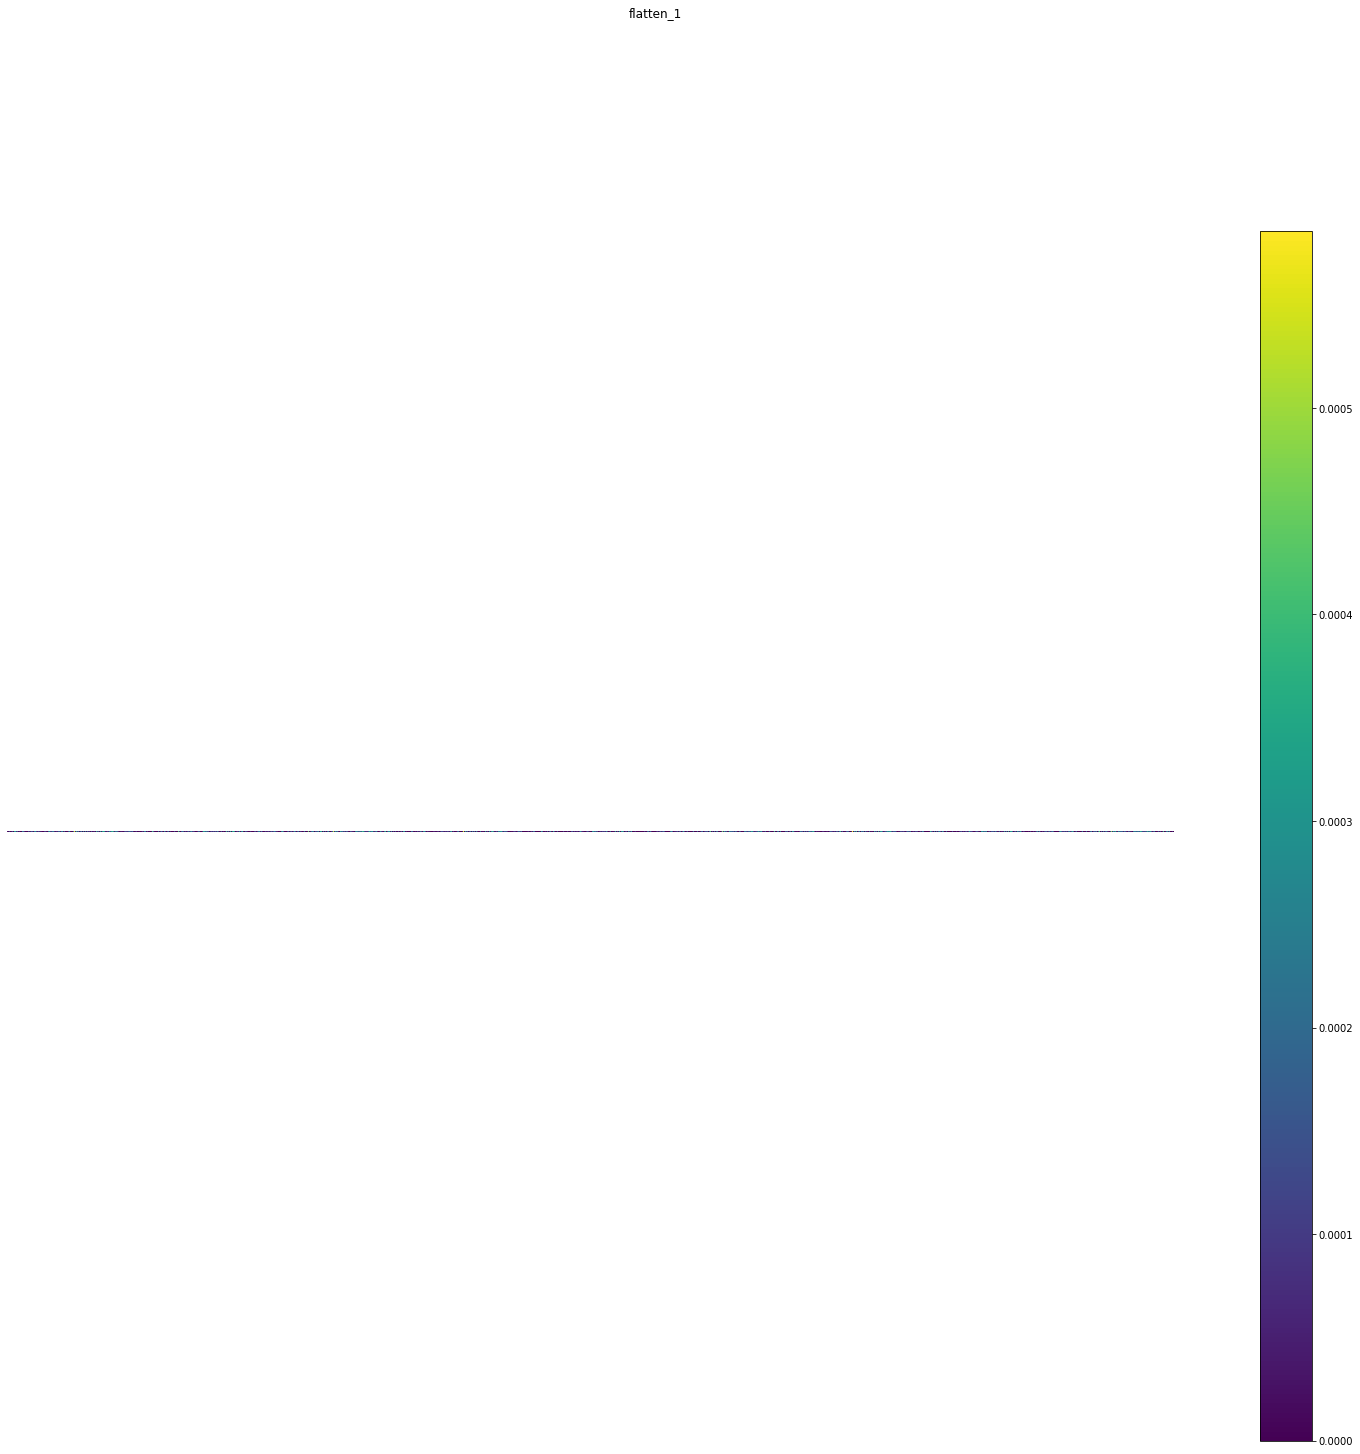

dense_2 (1, 128) 


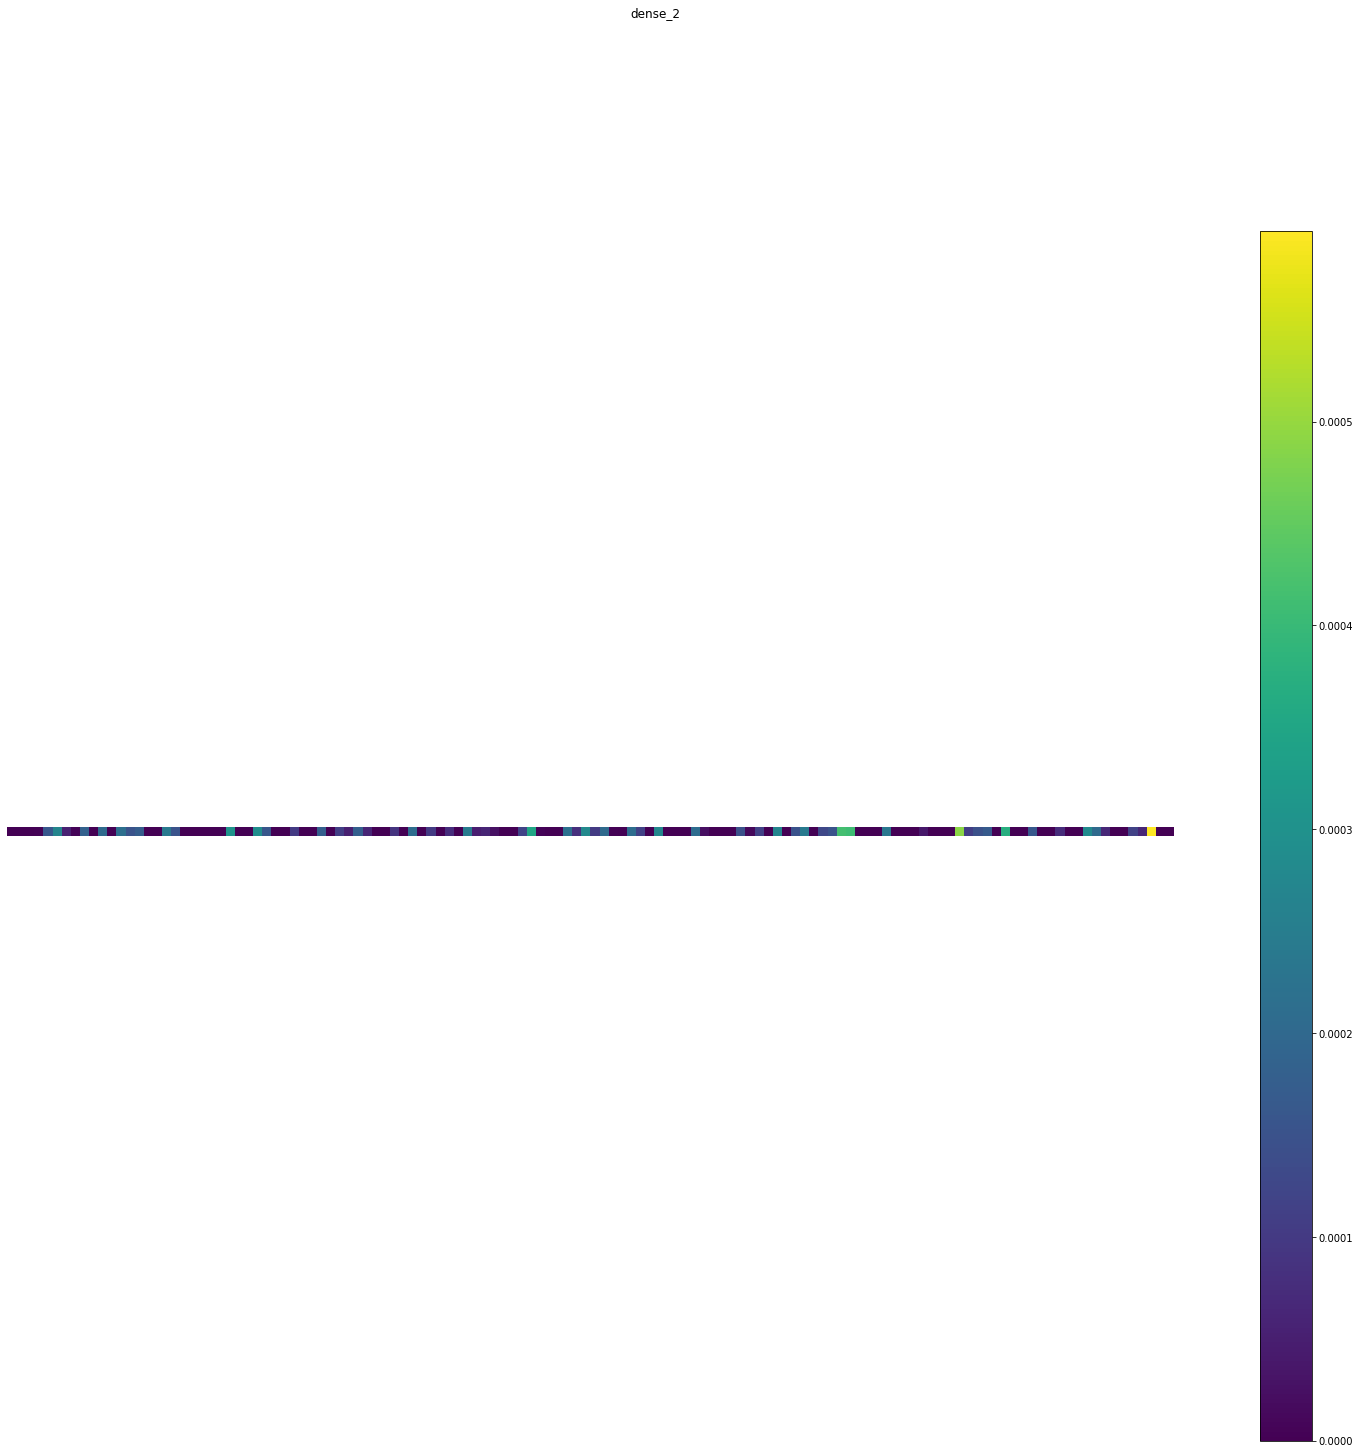

dense_3 (1, 1) 


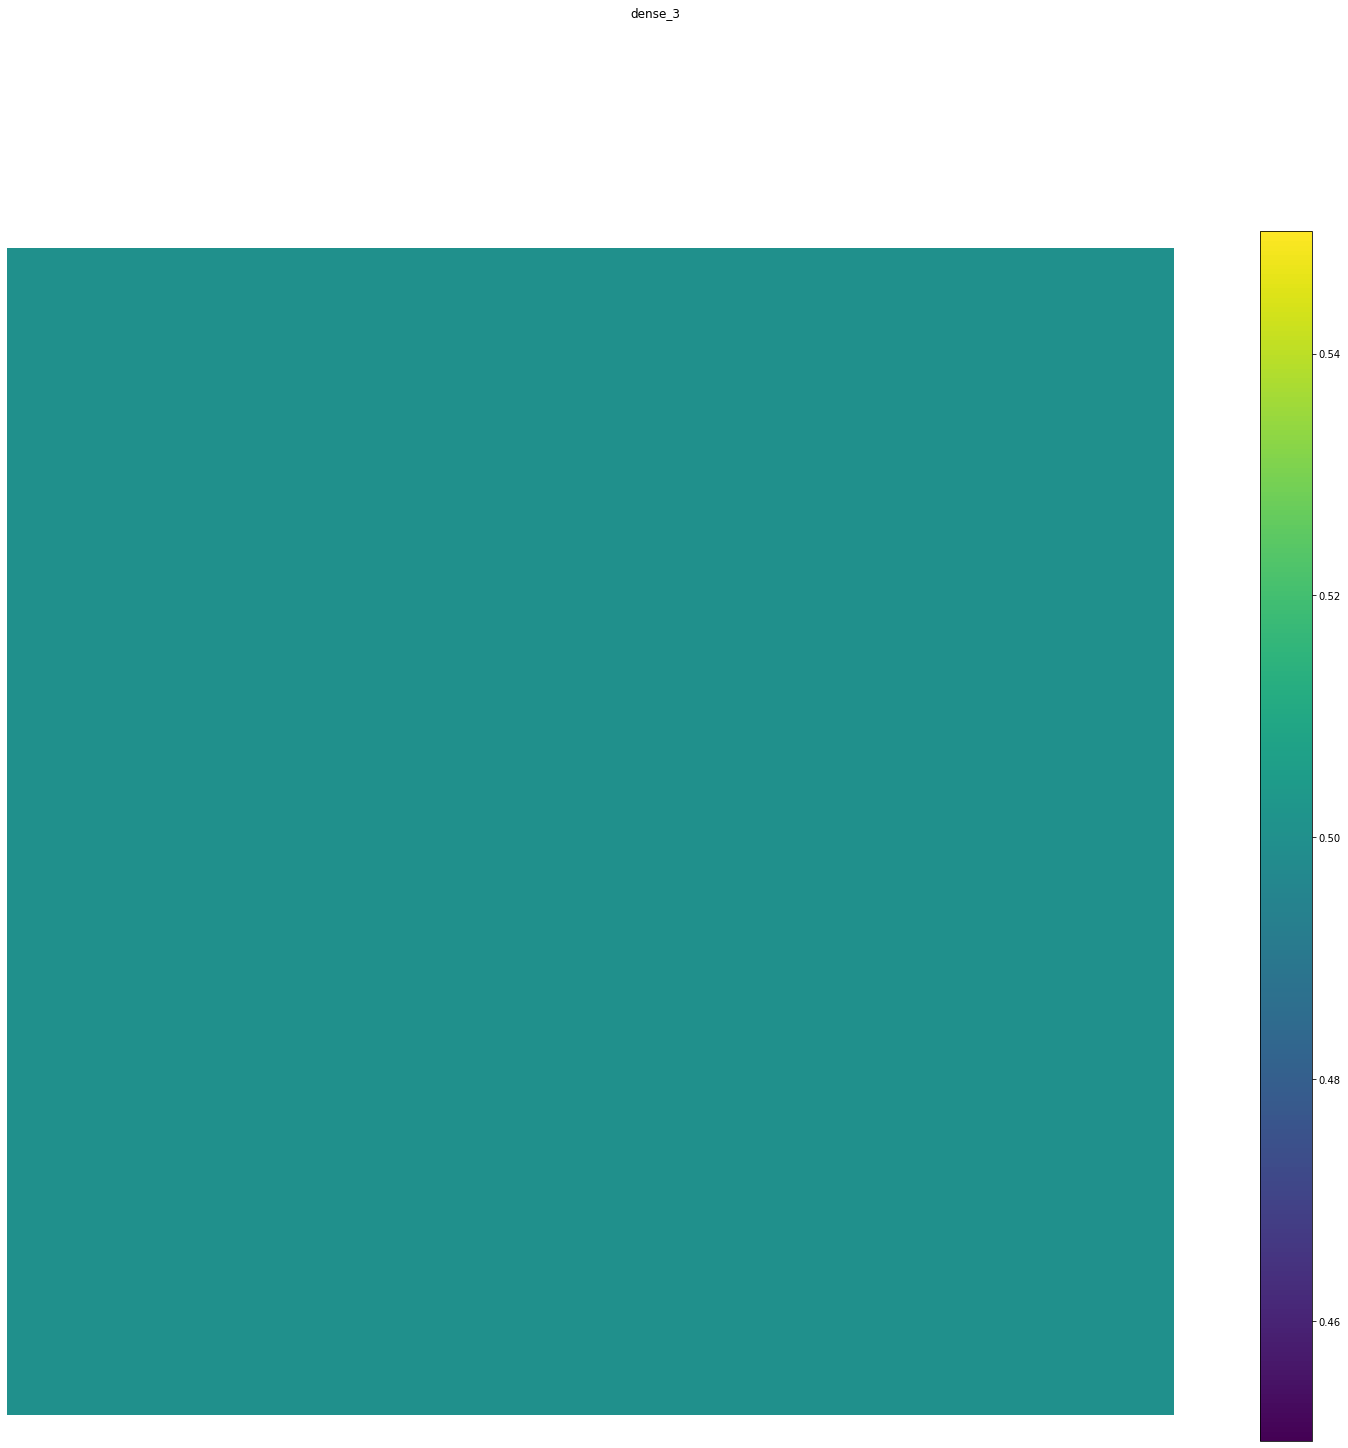

In [113]:
from keract import get_activations
from keract import display_activations
display_activations(activations, save=False)
activations = get_activations(model15, x)

In [50]:
def preprocess_image(img_path, model=None, rescale=255, resize=(50, 50)):
    """
    Preprocesses a given image for prediction with a trained model, with rescaling and resizing options
    
    Arguments:
            img_path: The path to the image file
            rescale: A float or integer indicating required rescaling. 
                    The image array will be divided (scaled) by this number.
            resize: A tuple indicating desired target size. 
                    This should match the input shape as expected by the model
    Returns:
            img: A processed image.
    """
    from keras.preprocessing.image import img_to_array, load_img
    import cv2
    import numpy as np

    assert type(img_path) == str, "Image path must be a string"
    assert (
        type(rescale) == int or type(rescale) == float
    ), "Rescale factor must be either a float or int"
    assert (
        type(resize) == tuple and len(resize) == 2
    ), "Resize target must be a tuple with two elements"

    img = load_img(img_path)
    img = img_to_array(img)
    img = img / float(rescale)
    img = cv2.resize(img, resize)
    if model != None:
        if len(model.input_shape) == 4:
            img = np.expand_dims(img, axis=0)

    return img
x = preprocess_image(img_path="/content/drive/Othercomputers/My Computer/final project/base_dir/val_dir/b_has_idc/10253_idx5_x501_y401_class1.png",model=model,resize=image_size)
model.predict(x)


array([[-7.751673]], dtype=float32)